# Hypothesis-driven and discovery-driven analysis with CEBRA

In this notebook, we show how to:

- use CEBRA-Time and CEBRA-Behavior and CEBRA-Hybrid in an hypothesis-driven or discovery-driven analysis.

- use CEBRA-Behavior more specifically in an hypothesis-driven analysis, by testing different hypothesis on positon and direction encoding. 

It is mostly based on what we present in [Figure 2](https://cebra.ai/docs/cebra-figures/figures/Figure2.html) in Schneider, Lee, Mathis.

## Load the data

In [1]:
"""# install
%pip install matplotlib numpy scipy sklearn pyyaml tqdm torch torchvision numba pandas h5py plotly pysanky
%pip install --pre cebra[datasets,demos]

# you should also install cuda for 10x faster computation 
%pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

# for mat to py conversion
#%pip install mat4py ???? #TODO: test and improve matlab files to python conversion

"""

'# install\n%pip install matplotlib numpy scipy sklearn pyyaml tqdm torch torchvision numba pandas h5py plotly pysanky\n%pip install --pre cebra[datasets,demos]\n\n# you should also install cuda for 10x faster computation \n%pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html\n\n# for mat to py conversion\n#%pip install mat4py ???? #TODO: test and improve matlab files to python conversion\n\n'

In [2]:
# install dependencies
#!pip install --pre --user cebra[datasets,demos]

# import 
import os
import numpy as np
from Classes import Animal, Vizualizer, load_all_animals, global_logger_object
from Classes import yield_animal_session_task, yield_animal_session, yield_animal, filter_dict_by_properties
from Classes import correlate_vectors
from Visualizer import *
import matplotlib.pyplot as plt
from cebra import CEBRA
import cebra
import torch
print(f"Cuda activated: {torch.cuda.is_available()}")

plt.style.use('dark_background')
%matplotlib inline
#%matplotlib tk
%autosave 180
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

if not os.path.exists("logs"):
    os.mkdir("logs")
global_logger_object.set_save_dir(os.path.join(os.getcwd(), "logs"))


Cuda activated: True


Autosaving every 180 seconds


Standard cebra models are initialized with default parameters:
 - `model_architecture="offset10-model"`
 - `batch_size=512`
 - `learning_rate=3e-4`
 - `temperature=1` or `temperature=1.12`
 - `output_dimension=3`
 - `max_iterations=5000`
 - `distance="cosine"`
 - `conditional="time_delta"` or `conditional="time"`
 - `device="cuda_if_available"`
 - `verbose=True`
 - `time_offsets=10`

In [3]:
# settings paths
root_dir = "D:\\Experiments"
#experimentalist = "Renan"
#paradigm = "VR"
experimentalist = "Steffen"
paradigm = "Rigid_Plastic" #Intrinsic Imaging
animal_root_dir = os.path.join(root_dir, experimentalist, paradigm)

# setting data to use
behavior_datas = ["position", "distance", "velocity", "moving", "acceleration", "stimulus"]
#movement_states = ["moving", "stationary", "all"]
wanted_animal_ids=["all"]
wanted_dates=["all"]
load_all = False
regenerate_plots=True
#regenerate_behavior_data=True

# cebra setting
regenerate=False
manifolds_pipeline="cebra"
# quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000
model_settings = {"place_cell": {"method" : "skaggs"}, 
                  "cebra": {"max_iterations" : 20000,  "output_dimension" : 3}} 


In [4]:
"""#initialize session
if load_all:
    animals = load_all_animals(animal_root_dir, 
             wanted_animal_ids=wanted_animal_ids, 
             wanted_dates=wanted_dates, 
             model_settings=model_settings,#) dont load data 
             behavior_datas=behavior_datas,
             regenerate_plots=regenerate_plots) # Load neural, behavior, data for all session parts.
    
    # load_data manually
    #for animal_id, animal in animals.items(): 
    #    animal.load_all_data(behavior_datas=behavior_datas)
    #    for session_date, session in animal.sessions.items():
    #        session.load_all_data(behavior_datas=behavior_datas)
else:
    animal = Animal(animal_id, root_dir=animal_root_dir)
    animal.add_session(date=session_date, 
                        model_settings=model_settings, 
                        behavior_data=behavior_datas)
    for session_date, session in animal.sessions.items():
        session.add_all_tasks() #tasks=["S1", "S2", "S3"])
        # Load neural, behavior, data for all session parts.
        data = session.load_all_data(behavior_datas=behavior_datas, 
                                     regenerate_plots=regenerate_plots)

# session specific data #TODO: combine all data for session
#session = None
# animal specific data #TODO: combine all data for animal\
#animal = None

# animals["DON-004366"].sessions["20210228"].tasks["S2"].behavior.stimulus.data
"""

'#initialize session\nif load_all:\n    animals = load_all_animals(animal_root_dir, \n             wanted_animal_ids=wanted_animal_ids, \n             wanted_dates=wanted_dates, \n             model_settings=model_settings,#) dont load data \n             behavior_datas=behavior_datas,\n             regenerate_plots=regenerate_plots) # Load neural, behavior, data for all session parts.\n    \n    # load_data manually\n    #for animal_id, animal in animals.items(): \n    #    animal.load_all_data(behavior_datas=behavior_datas)\n    #    for session_date, session in animal.sessions.items():\n    #        session.load_all_data(behavior_datas=behavior_datas)\nelse:\n    animal = Animal(animal_id, root_dir=animal_root_dir)\n    animal.add_session(date=session_date, \n                        model_settings=model_settings, \n                        behavior_data=behavior_datas)\n    for session_date, session in animal.sessions.items():\n        session.add_all_tasks() #tasks=["S1", "S2", "S3"

## Testing for Place Cells

Loading D:\Experiments\Steffen\Rigid_Plastic\DON-004366\20210228\002P-F\tif\suite2p\plane0\DON-004366_20210228_S1_photon.npy
Data is probably transposed. Needed Shape [Time, cells] Transposing...
No position data found at D:\Experiments\Steffen\Rigid_Plastic\DON-004366\20210228\TRD-2P\DON-004366_20210228_S1_position.npy.
Loading D:\Experiments\Steffen\Rigid_Plastic\DON-004366\20210228\TRD-2P\DON-004366_20210228_S1_distance.npy
Loading D:\Experiments\Steffen\Rigid_Plastic\DON-004366\20210228\TRD-2P\DON-004366_20210228_S1_velocity.npy
Data is probably transposed. Needed Shape [Time, cells] Transposing...
No moving data found at D:\Experiments\Steffen\Rigid_Plastic\DON-004366\20210228\TRD-2P\DON-004366_20210228_S1_moving.npy.
Creating moving dataset based on raw data from velocity.
Loading D:\Experiments\Steffen\Rigid_Plastic\DON-004366\20210228\TRD-2P\DON-004366_20210228_S1_acceleration.npy
Data is probably transposed. Needed Shape [Time, cells] Transposing...
Loading D:\Experiments\Stef

c:\Users\mauls\OneDrive\Dokumente\Code\MetaCEBRA\CEBRA_own\Visualizer.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=plot_attributes["figsize"])


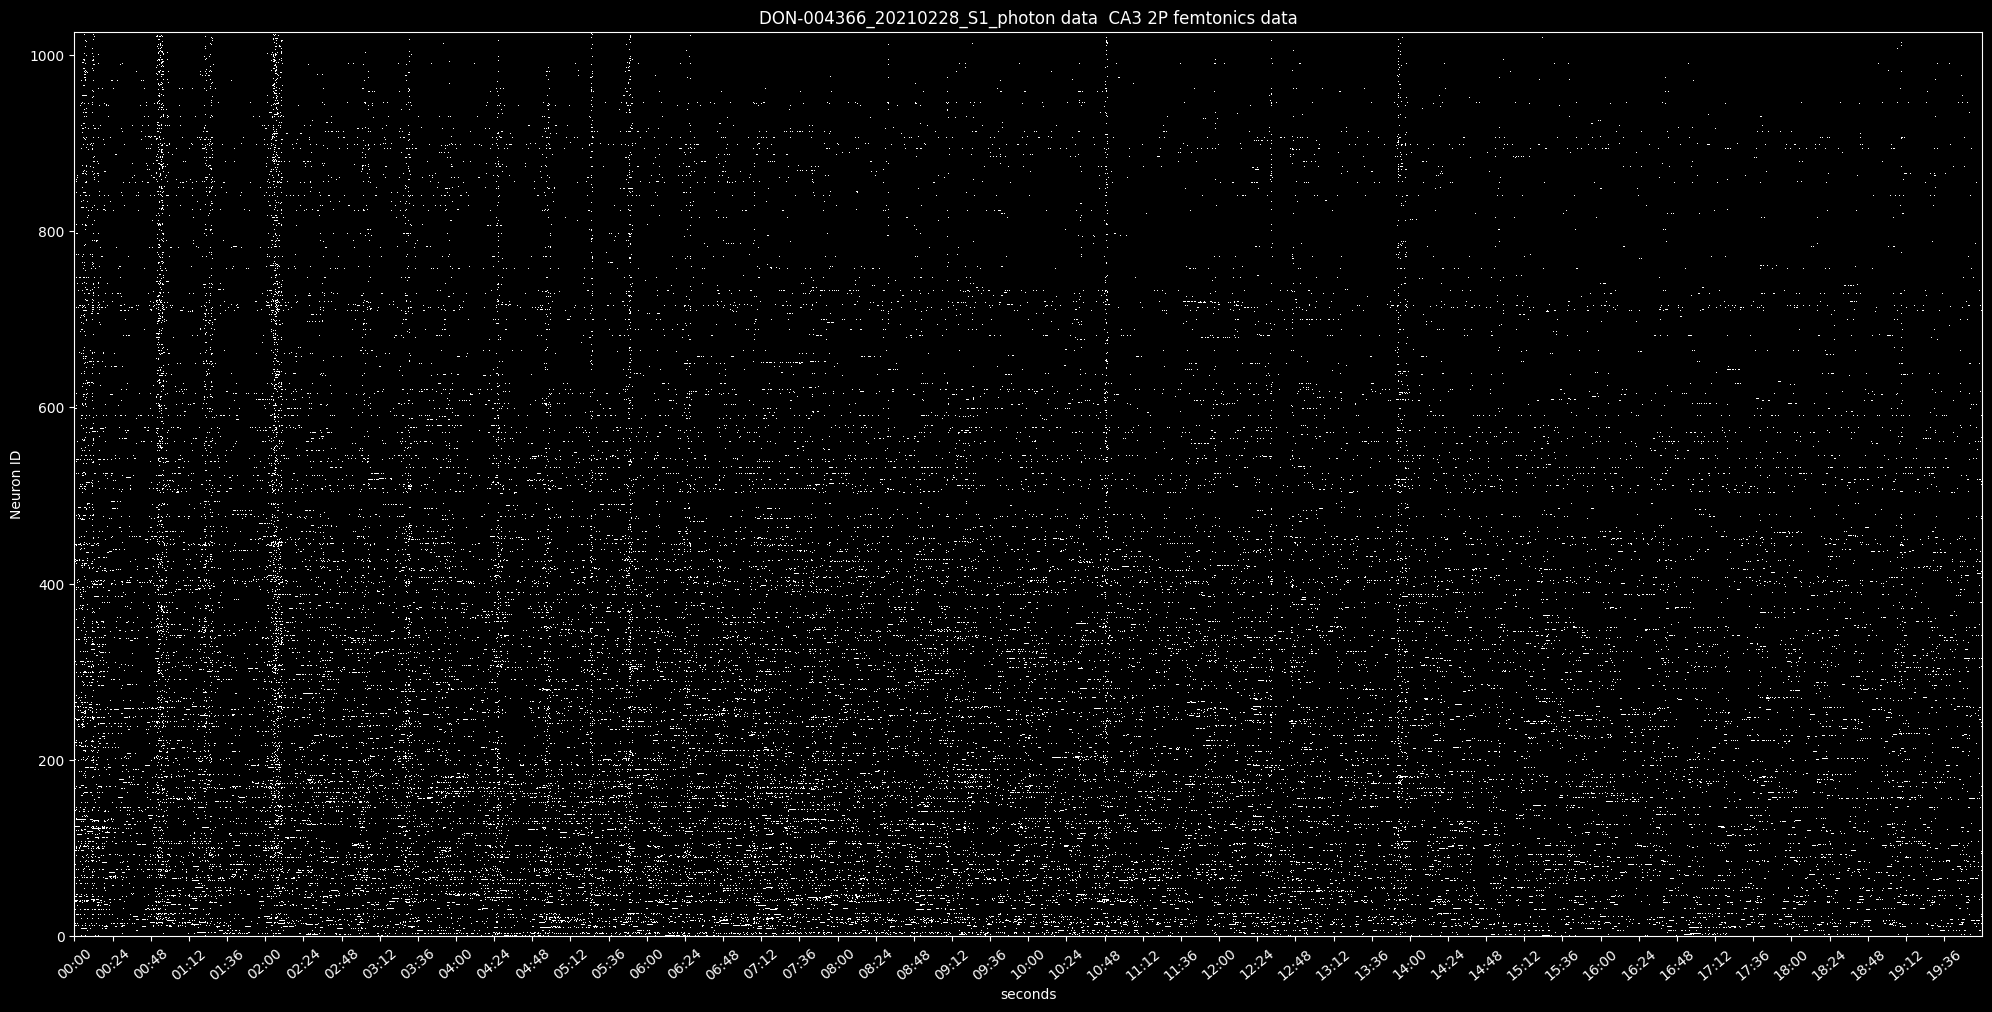

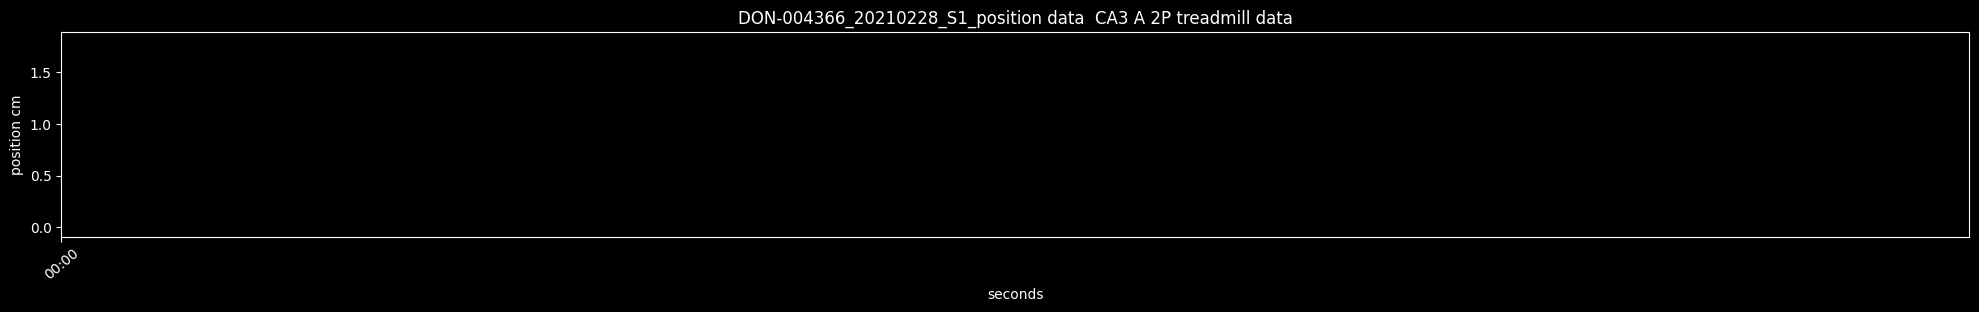

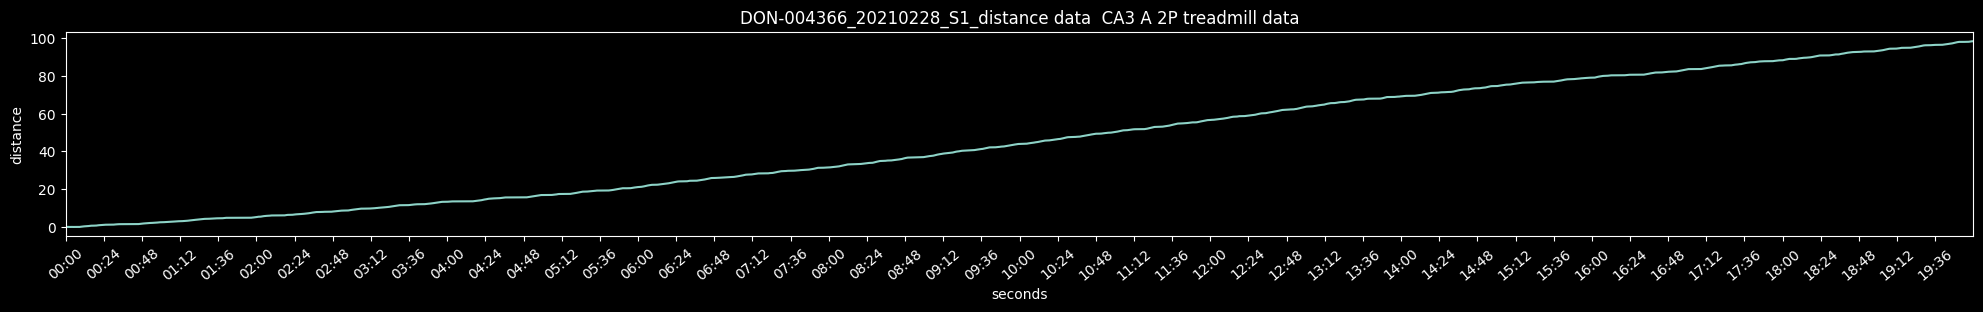

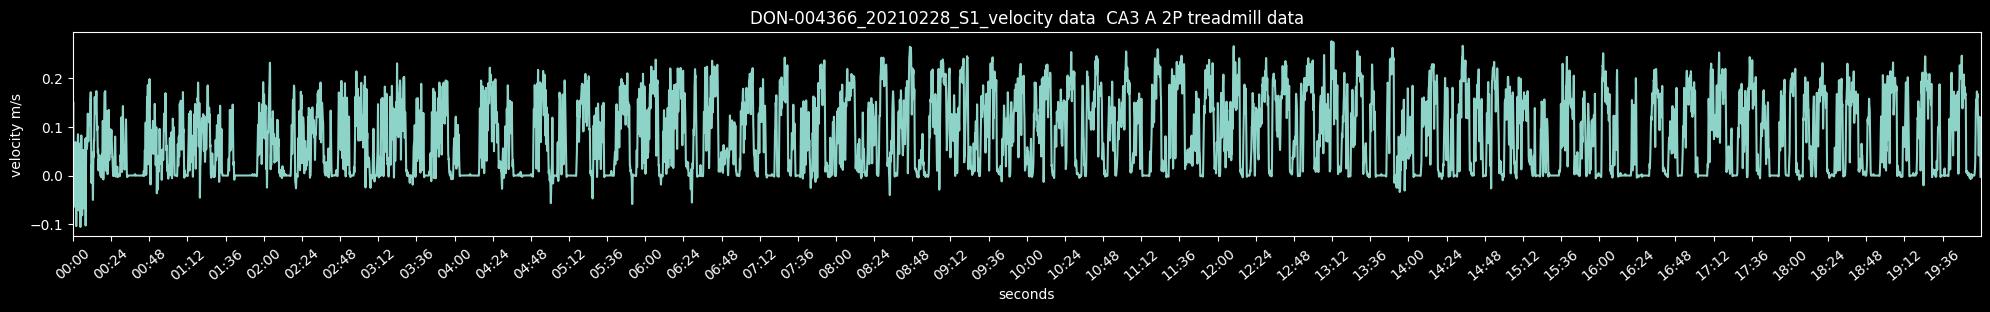

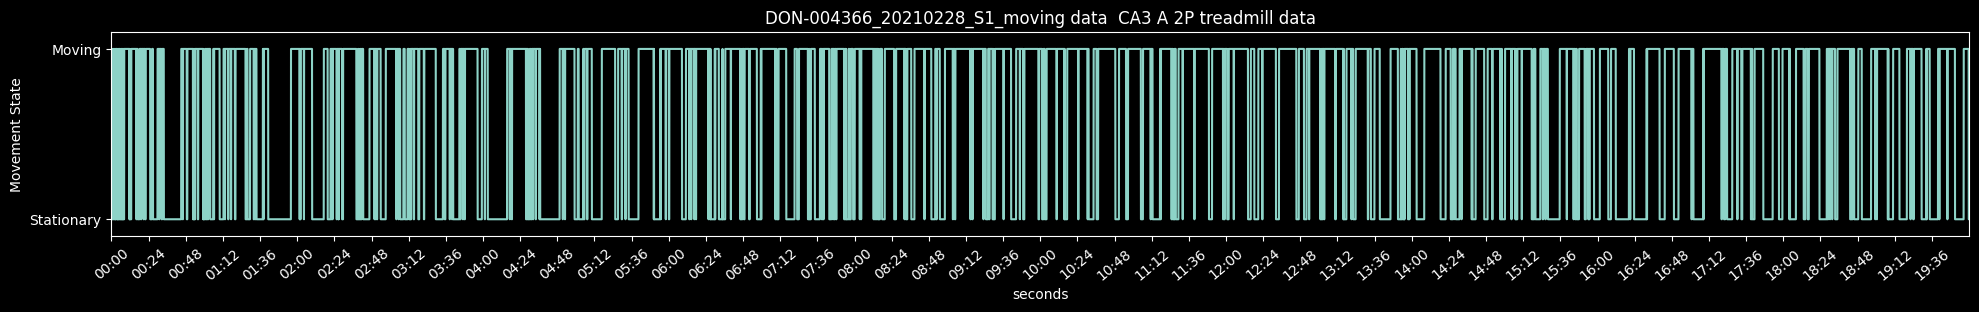

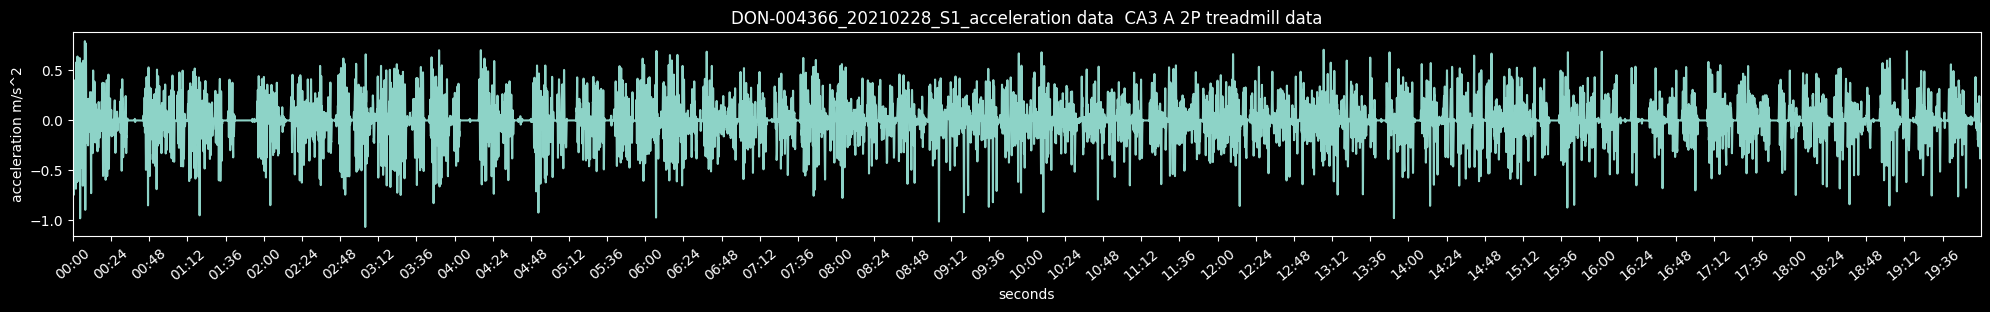

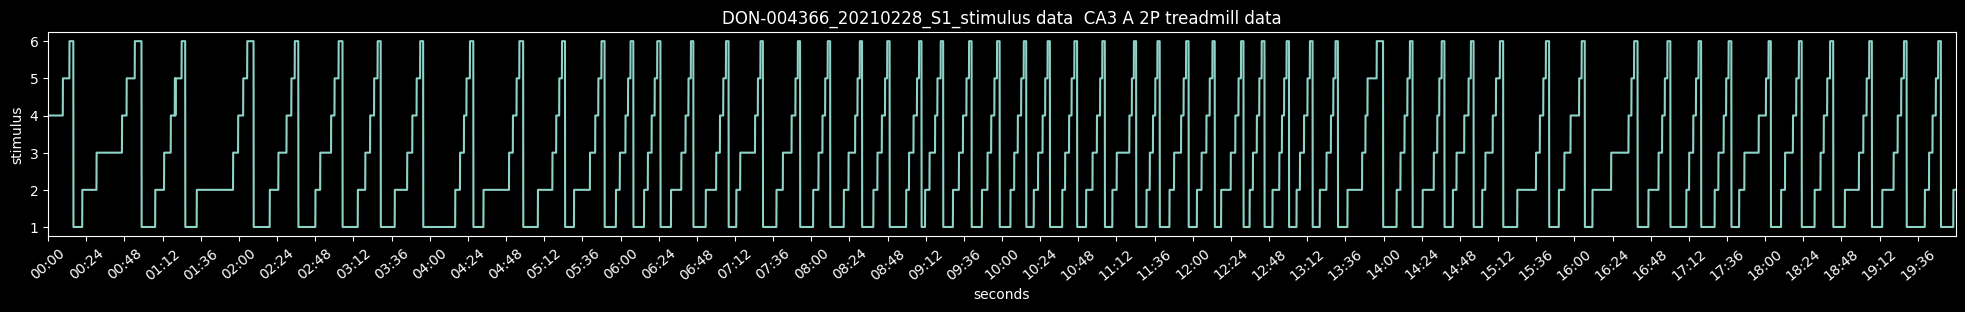

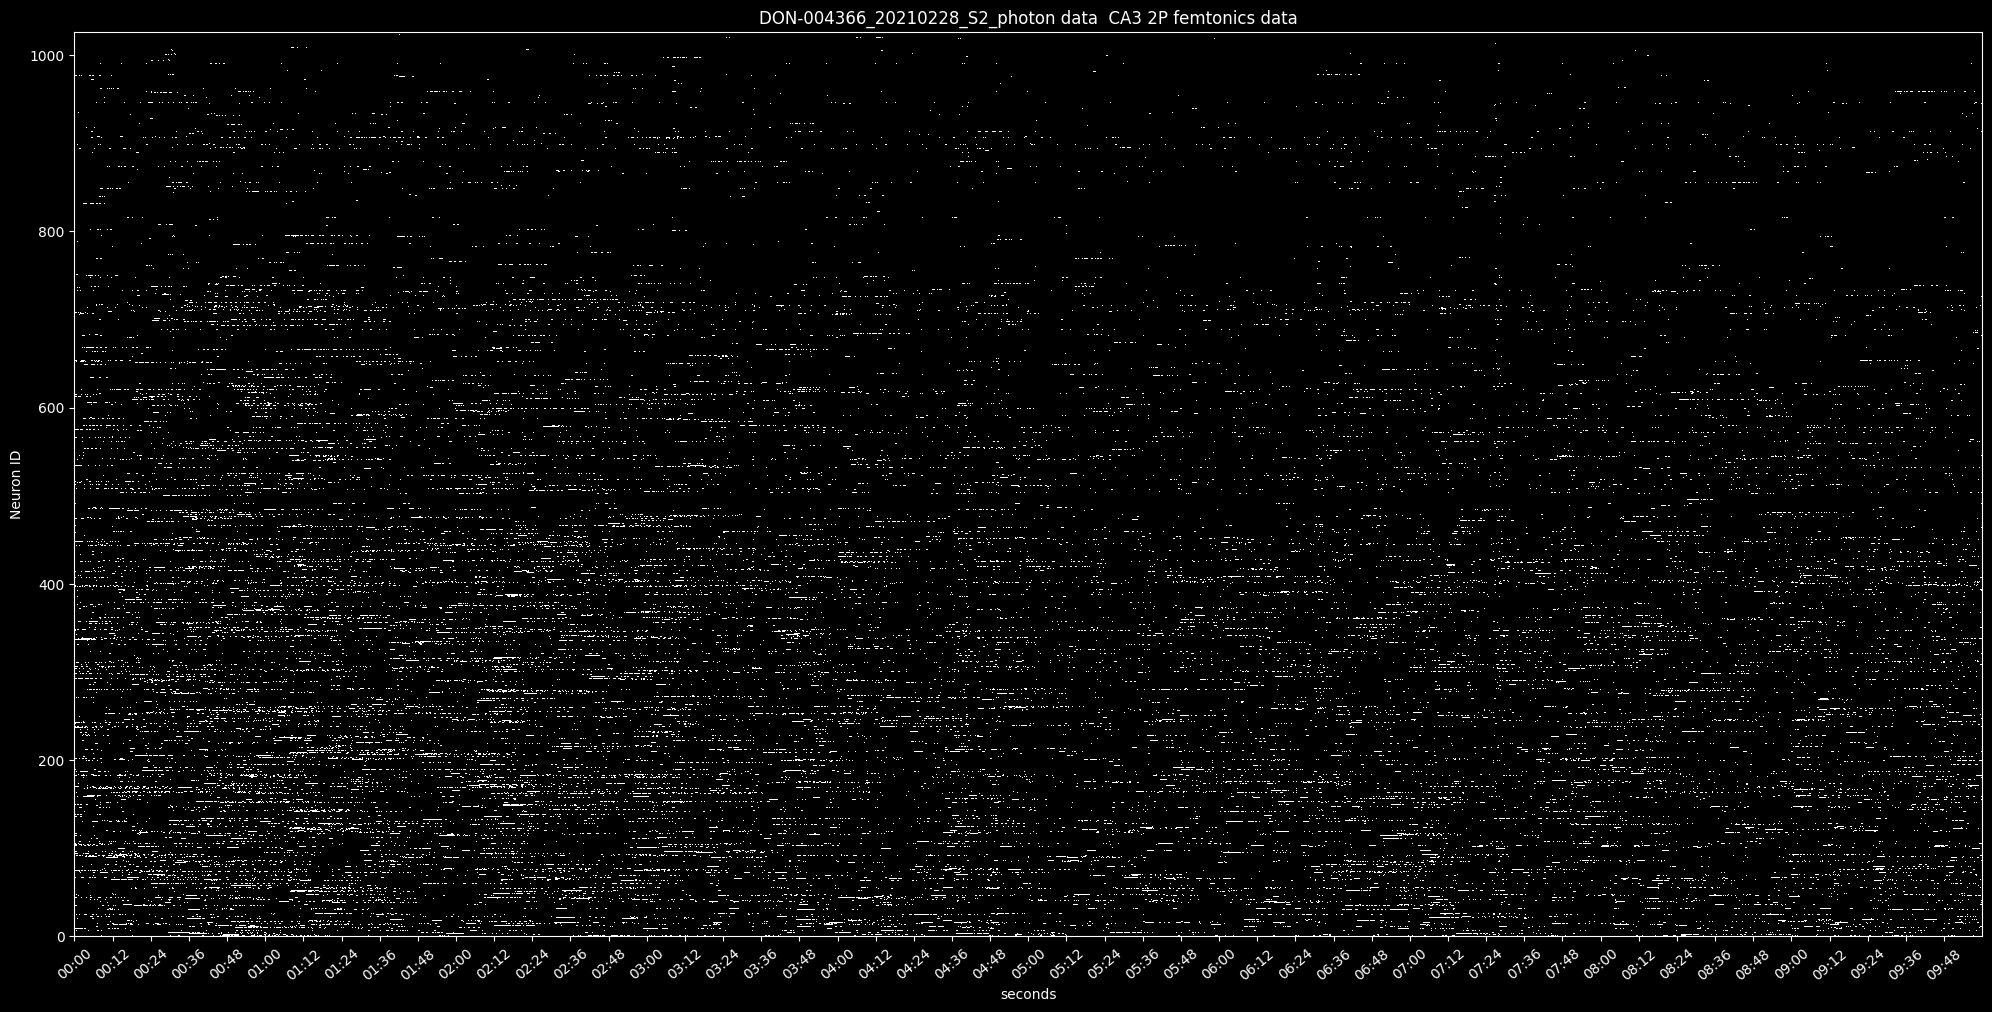

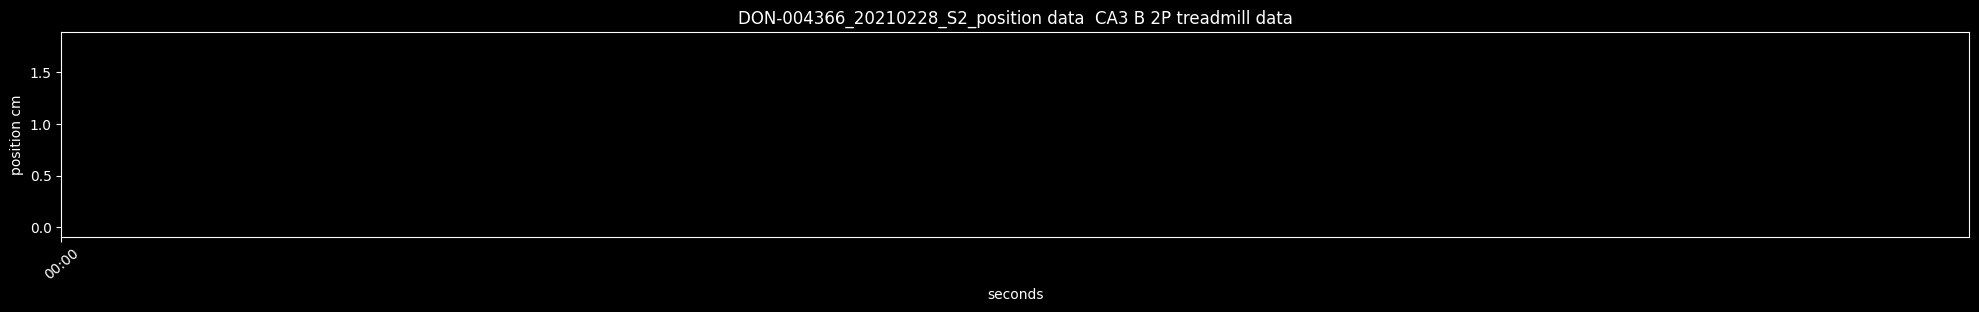

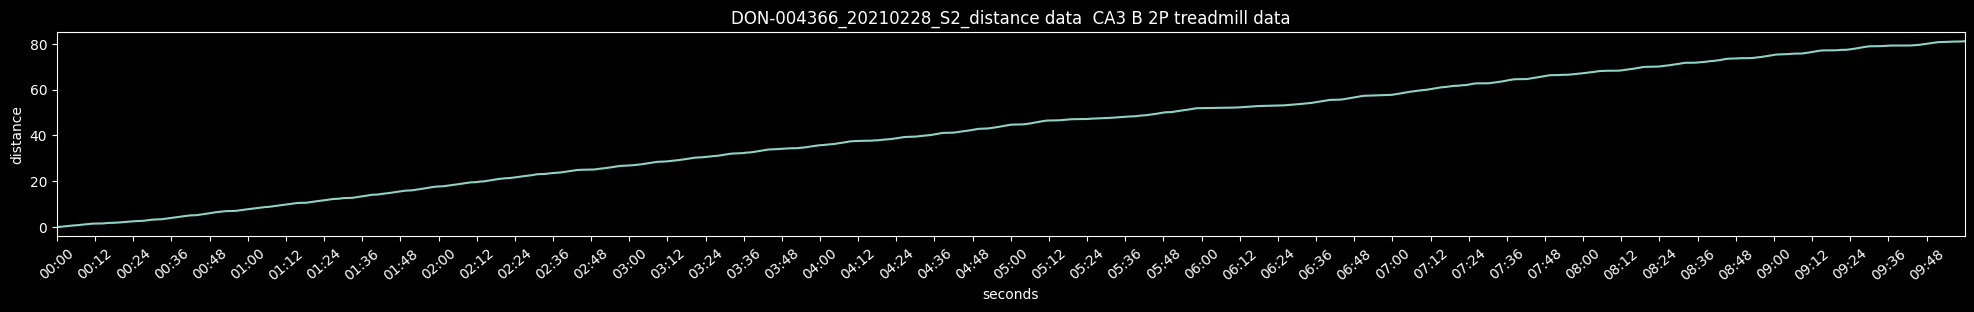

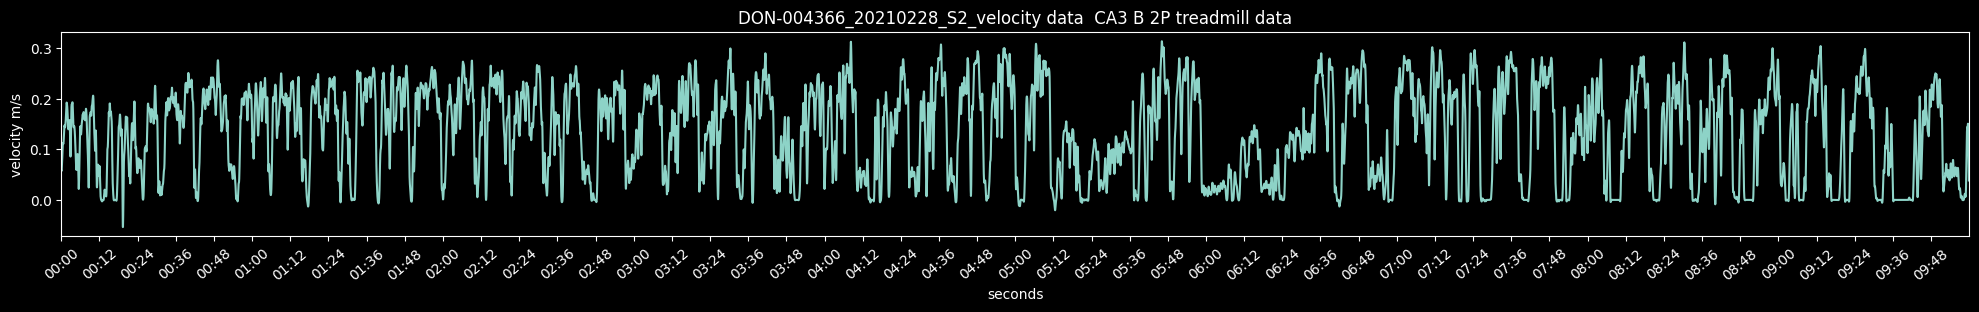

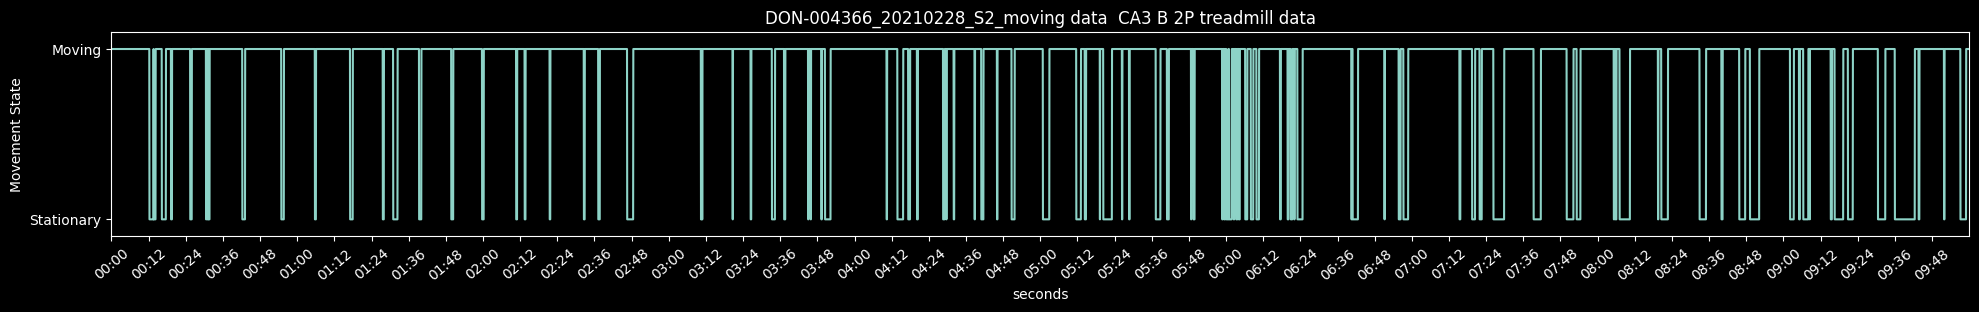

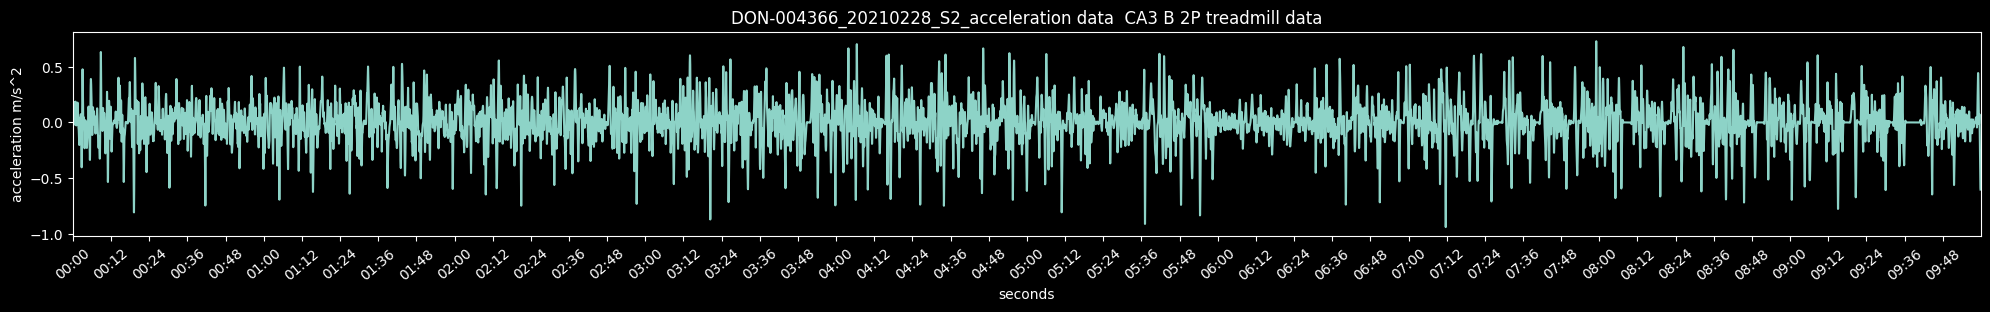

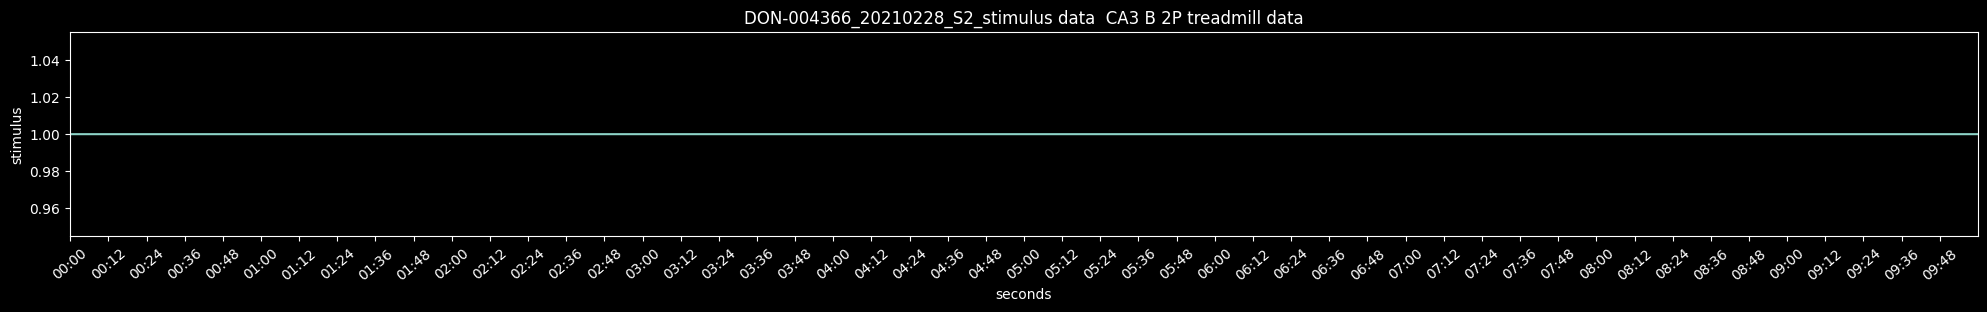

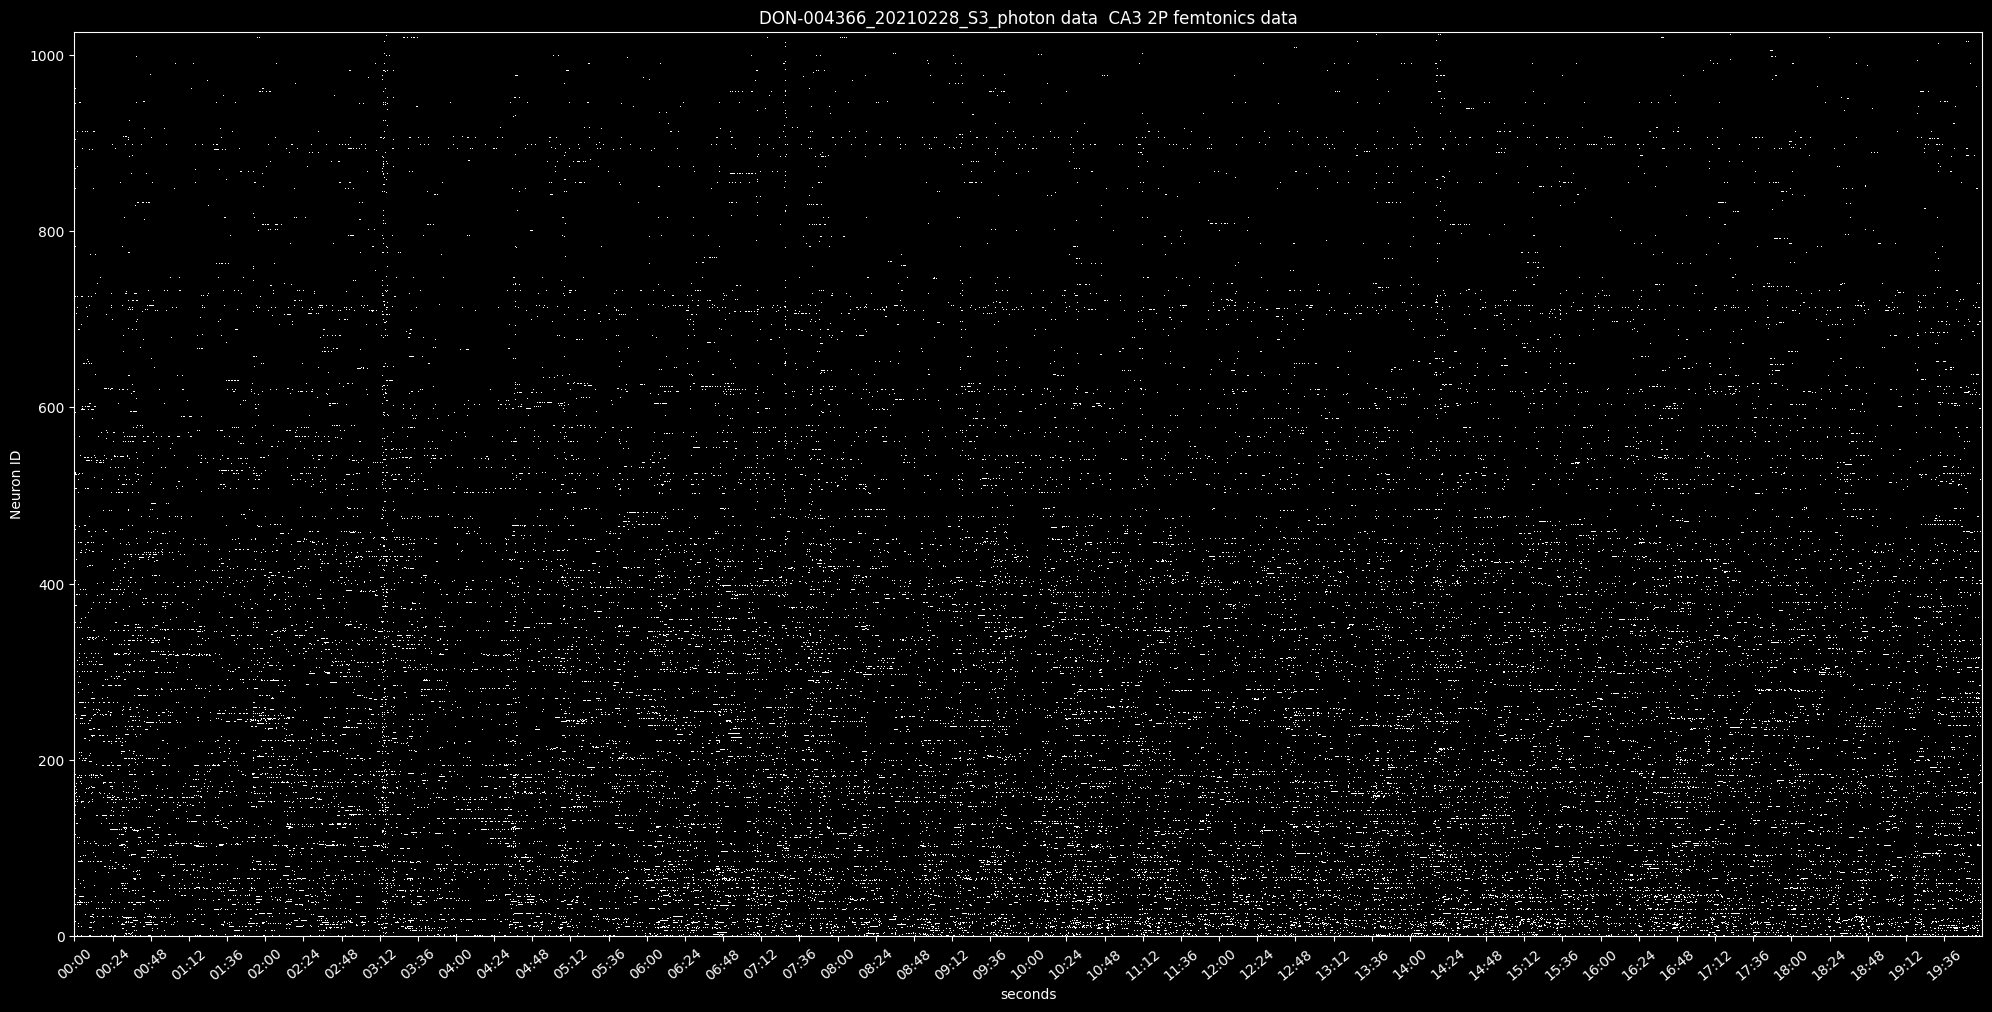

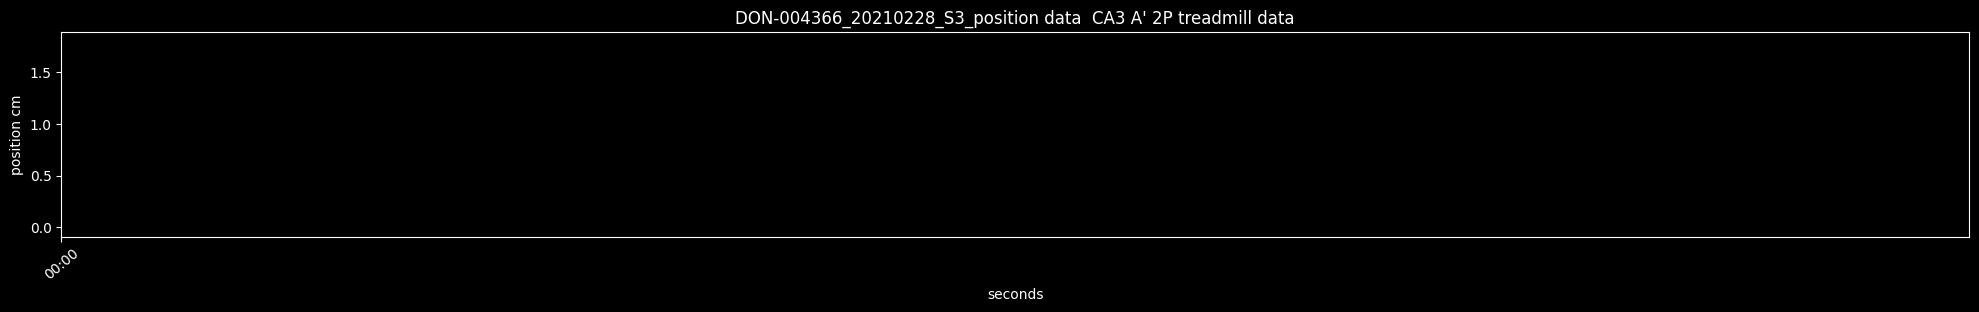

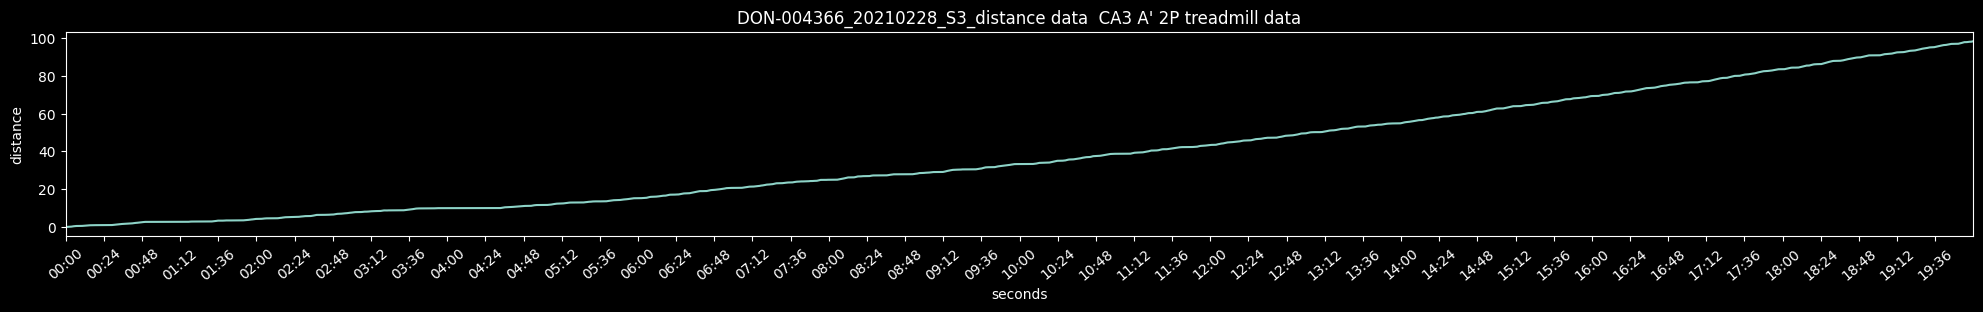

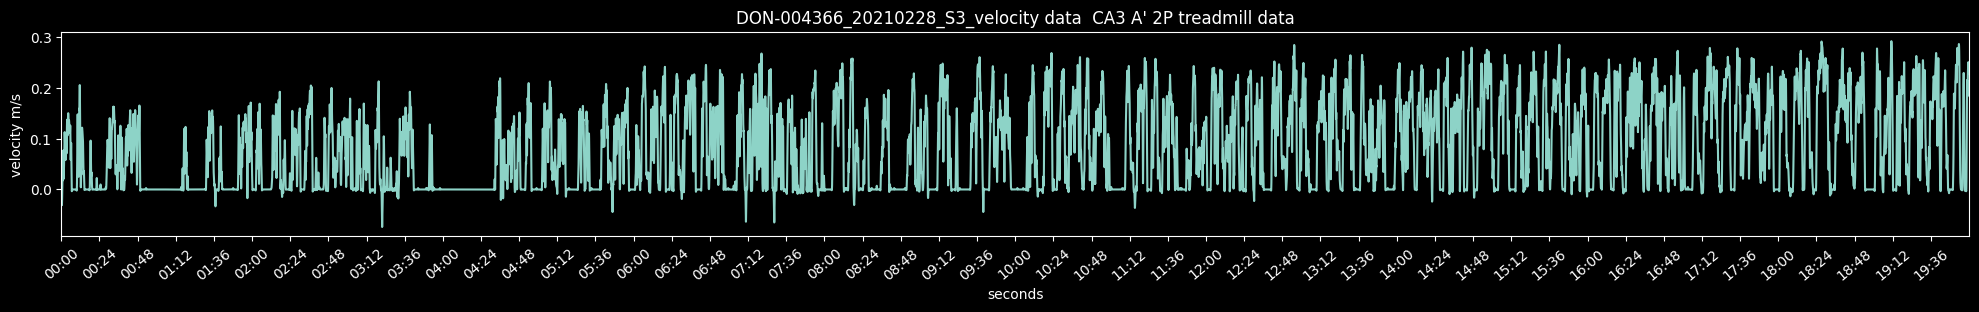

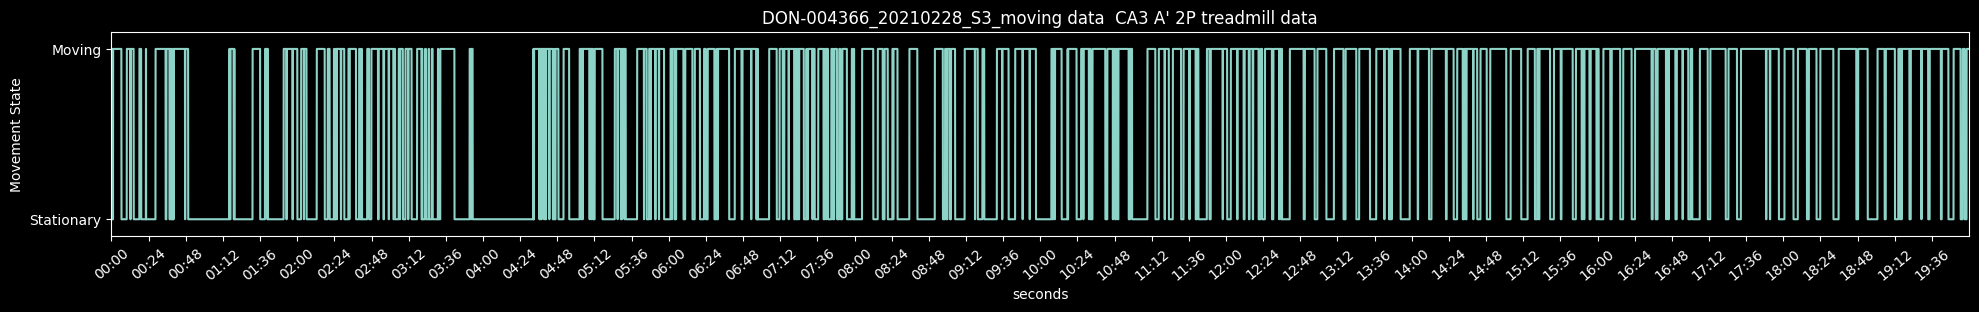

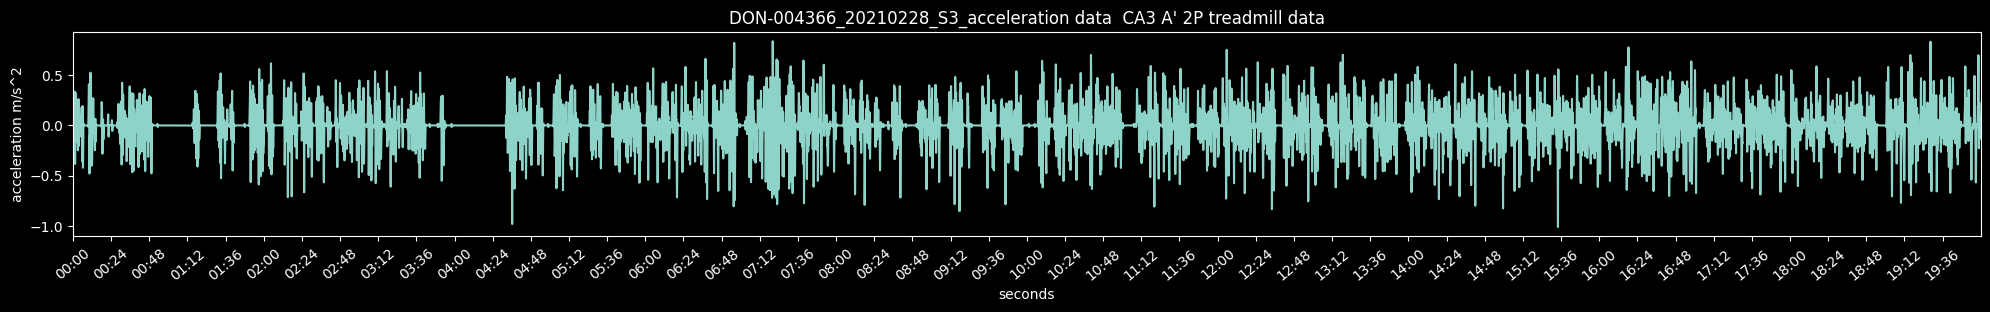

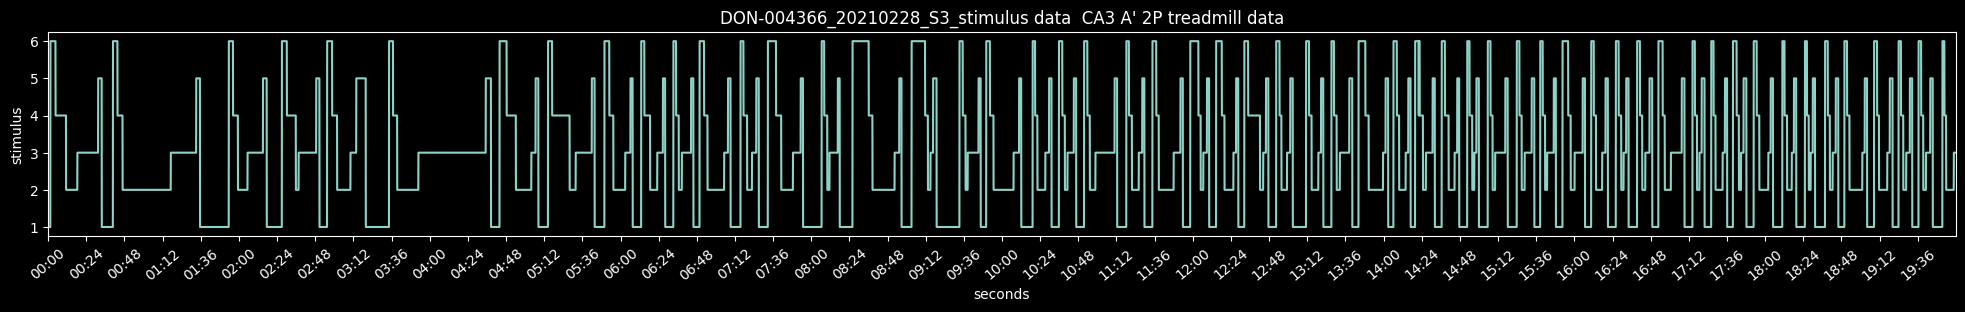

In [5]:
# Settings 
#experimentalist = "Renan"
#paradigm = "VR"
experimentalist = "Steffen"
paradigm = "Rigid_Plastic" #Intrinsic Imaging
animal_root_dir = os.path.join(root_dir, experimentalist, paradigm)
# setting data to use
behavior_datas = ["position", "distance", "velocity", "moving", "acceleration", "stimulus"]
regenerate_plots=True
# cebra setting
regenerate=False
manifolds_pipeline="cebra"
# quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000
model_settings = {"place_cell": {"method" : "skaggs"}, 
                  "cebra": {"max_iterations" : 20000,  "output_dimension" : 3}} 

## Task
# TODO: create dataset for place cell detection testing
artificial_task = False
if artificial_task:
    animal_id = "DON-999999"
    session_date = "19991219"
    task = "S1"
else:
    animal_id = "DON-004366"
    session_date = "20210228"
    task = "S1"

animal = Animal(animal_id, root_dir=animal_root_dir)
animal.add_session(date=session_date, 
                    model_settings=model_settings, 
                    behavior_data=behavior_datas)
for session_date, session in animal.sessions.items():
    session.add_all_tasks() #tasks=["S1", "S2", "S3"])
    #session.add_task("S2", metadata=session.tasks_infos["S2"])
    # Load neural, behavior, data for all session parts.
    data = session.load_all_data(behavior_datas=behavior_datas, regenerate_plots=regenerate_plots)

## load task
if "animals" in globals():
    animal = animals[animal_id]
session = animal.sessions[session_date]
#task = session.tasks[task]

### Place cell detection

#### Catalin

In [ ]:
from scipy.spatial import cKDTree
import h5py
import os
import numpy as np
from tqdm import tqdm, trange
from scipy import stats
import matplotlib.pyplot as plt
import pickle


#
class Treadmill:

    def __init__(
        self,
        tasks
    ):
        self.tasks=tasks

    def compute_rate_maps(self):
        """This only computes the average activity at eac

        :param min_vel:
        :return:
        """

        # find moving
        self.ca = {}
        self.pos = {}
        self.rate_maps_non_norm = {}
        self.n_frames_in_loc = {}
        self.rate_maps = {}
        for task_id, task in self.tasks.items():
            idx_to_keep = task.behavior.moving.data

            from Datasets import Dataset
            ca = Dataset.filter_by_idx(
                task.neural.photon.data, idx_to_keep=idx_to_keep
            )
            pos = Dataset.filter_by_idx(
                task.behavior.position.binned_data, idx_to_keep=idx_to_keep
            )


            rate_map, time_map = task.models.place_cell.get_maps(
                activity=ca,
                binned_pos=pos,
                norm_occupancy=False,
                smooth=False,
                window_size=2,
            )

            # do time binned averages by adding activity at eveyr position
            self.rate_maps_non_norm[task.id] = rate_map
            rate_map, time_map = task.models.place_cell.get_maps(
                activity=ca,
                binned_pos=pos,
                norm_occupancy=True,
                smooth=False,
                window_size=2,
            )

            self.pos[task.id] = time_map
            for k in range(rate_map.shape[0]):
                max_ = np.nanmax(rate_map[k])
                min_ = np.nanmin(rate_map[k])
                if max_ == min_:
                    pass
                else:
                    rate_map[k] = (rate_map[k] - min_) / (max_ - min_)

            #
            self.ca[task.id] = rate_map
            self.n_frames_in_loc[task.id] = time_map
            self.rate_maps[task.id]=rate_map

            #
            print("rate maps: ", self.rate_maps[task.id].shape)

            ##############################
            ##############################
            ##############################
            plt.figure()
            # reorder cells
            if self.reorder_for_vis:
                idx = np.argmax(rate_map, axis=1)
                idx2 = np.argsort(idx)
                rate_map = rate_map[idx2]

            plt.imshow(rate_map, aspect="auto")
            plt.title(task.id)
            plt.xlabel("Track (cm)")
            plt.ylabel("Cell #")

            plt.show(block=False)

    def compute_si(self):

        self.si = {}
        self.si_rate = {}
        self.zscore = {}

        for task_id, task in self.tasks.items():
            time_map = self.pos[task.id]
            print("time_map :", time_map.shape)
            rate_map = self.rate_maps_non_norm[task.id]
            #rate_map = self.ca[task.id]

            #
            inf_rate, inf_content = get_si2(rate_map, time_map)

            #
            self.si_rate[task.id] = inf_rate
            self.si[task.id] = inf_content

            # get zscore:
            si_shuffle = np.zeros((self.n_tests, rate_map.shape[0]))
            for k in range(self.n_tests):
                time_map2 = np.roll(
                    time_map, np.random.choice(np.arange(time_map.shape[0]), 1)
                )
                inf_rate, _ = get_si(rate_map, time_map2)
                si_shuffle[k] = inf_rate

            from scipy import stats

            stack = np.vstack([self.si_rate[task.id], si_shuffle])
            self.zscore[task.id] = stats.zscore(stack, axis=1)[0]
        # print (zz[0])


    def show_zscore_examples(self):
        std_threshold = 2.5
        ###################
        np.logical_and(
            self.zscore[self.session_id] < 0.5, self.zscore[self.session_id] > -0.5
        )[0]
        plt.figure()
        plt.suptitle(task.id)
        ax = plt.subplot(3, 1, 1)
        plt.title("low zscores")
        width = 11
        for k in range(10):
            try:
                temp = self.rate_maps_non_norm[self.session_id][idx[k]]
                temp = np.convolve(temp, np.ones(width) / width, mode="same")
                plt.plot(temp / self.n_frames_in_loc[self.session_id] + k * 0.3)
                plt.plot(temp * 0 + k * 0.3, "--", c="grey")
            except:
                pass

        ##########################
        ax = plt.subplot(3, 1, 2)
        idx = np.where(self.zscore[self.session_id] > std_threshold)[0]
        plt.title("> " + str(std_threshold) + " std")
        for k in range(10):
            try:
                temp = self.rate_maps_non_norm[self.session_id][idx[k]]
                temp = np.convolve(temp, np.ones(width) / width, mode="same")
                plt.plot(temp / self.n_frames_in_loc[self.session_id] + k * 0.3)
                plt.plot(temp * 0 + k * 0.3, "--", c="grey")
            except:
                pass

        ##############################
        ax = plt.subplot(3, 1, 3)
        idx = np.where(self.zscore[self.session_id] < -std_threshold)[0]
        plt.title("< -" + str(std_threshold) + " std")
        for k in range(10):
            try:
                temp = self.rate_maps_non_norm[self.session_id][idx[k]]
                temp = np.convolve(temp, np.ones(width) / width, mode="same")
                plt.plot(temp / self.n_frames_in_loc[self.session_id] + k * 0.3)
                plt.plot(temp * 0 + k * 0.3, "--", c="grey")
            except:
                pass
        plt.xlabel("Belt (cm)")
        plt.show(block=False)

    def zscore_si_histogram(self):
        std_threshold = 2.5
        for task_id, task in self.tasks.items():
            idx = np.where(np.abs(self.zscore[task.id]) >= std_threshold)[0]
            # print ("idx of cells > threshold zscore ", idx)
            self.cell_ids_above_threshold = idx

            plt.figure()
            plt.title(
                f"Zscore distributions - Seg {task.behavior.metadata['stimulus_type']} , std threshold {std_threshold}")
            plt.hist(self.zscore[task.id], label=f"# place cells: {idx.shape[0]}, {idx.shape[0] / self.zscore[task.id].shape[0] * 100:.1f}%")
            plt.ylabel("# cells")
            plt.xlabel("Zscore")
            plt.legend()
            plt.show(block=False)

    def compute_pairse_correlation_distributions(
        imgs,
        session_ids,
        offset,
        unscramble,
        pval_thresh,
        corr_thresh,
        scramble_order,
        shuffle=False,
    ):
        #
        sess1 = imgs[session_ids[0]].copy()
        sess2 = imgs[session_ids[1]].copy()

        #
        corrs = []
        pvals = []
        locs = []
        peaks = []
        changes = []
        stacks = []
        ctr = 0

        # loop over all cells
        for k in range(sess1.shape[0]):

            # load the cell
            seg1 = sess1[k]
            #
            seg2 = sess2[k]
            if shuffle:
                # print (seg2.shape)
                # print(np.arange(5000, seg2.shape[0]-5000,1))
                seg2 = np.roll(
                    seg2,
                    np.random.choice(np.arange(0, 180, 1), 1),
                    # 60
                )

            #
            if unscramble:
                temp = seg2.copy()
                for k in range(6):
                    # print (k, k+30, scramble_order[k], scramble_order[k]+30)
                    seg2[k * 30 : k * 30 + 30] = temp[
                        scramble_order[k] * 30 : scramble_order[k] * 30 + 30
                    ]

            #
            try:
                res = stats.pearsonr(seg1[offset:], seg2[offset:])
            except:
                continue

            #
            corr = res[0]
            pval = res[1]

            #
            if pval < pval_thresh and abs(corr) > corr_thresh:
                corrs.append(res[0])
                pvals.append(res[1])

                #
                loc = np.argmax(seg1[offset:]) + offset
                locs.append(loc)

                #
                peak1 = np.argmax(seg1[offset:]) + offset
                peak2 = np.argmax(seg2[offset:]) + offset
                peaks.append([peak1, peak2])

                #
                changes.append(peak1 - peak2)

                #
                if corr > corr_thresh:
                    seg1 = seg1[offset:]
                    seg2 = seg2[offset:]
                    stacks.append((seg1 - np.min(seg1)) / (np.max(seg1 - np.min(seg1))))
                    stacks.append((seg2 - np.min(seg2)) / (np.max(seg2 - np.min(seg2))))
                    stacks.append(seg1 * 0)

                #
                ctr += 1
        #
        return np.array(corrs), np.array(locs), peaks, changes, stacks

    def show_rigid_cells_from_correlations(self):
        idx = np.where(np.abs(self.zscore[self.session_id]) >= std_threshold)[0]
        print(idx.shape)

        # grab the rate maps
        r1 = self.rate_maps[0][idx]
        print(r1.shape)

        r2 = self.rate_maps[2][idx]
        print(r2.shape)

        #
        corrs = []
        pvals = []
        for k in range(r1.shape[0]):
            res = stats.pearsonr(r1[k], r2[k])
            corrs.append(res[0])
            pvals.append(res[1])
        pvals = np.array(pvals)
        corrs = np.array(corrs)

        plt.figure()
        n_place = idx.shape[0]
        plt.suptitle(" Total # place cells: " + str(n_place) + " in session A")
        y = np.histogram(corrs, bins=np.arange(-1, 1, 0.05))
        plt.bar(y[1][:-1], y[0], width=0.04, label="non-rigid")

        #
        idx = np.where(np.abs(y[1][:-1]) >= 0.3)[0]
        print("idx: ", idx)
        plt.bar(
            y[1][:-1][idx],
            y[0][idx],
            width=0.04,
            label="rigid (pcorr>0.3) :" + str(y[0][idx].sum()),
        )
        plt.legend()
        plt.xlabel("Pearson corr")
        plt.ylabel("# cells")
        plt.show(block=False)

        ##############################################
        plt.figure()
        y = np.histogram(pvals, bins=np.arange(0, 1, 0.05))
        plt.bar(y[1][:-1], y[0], width=0.04)
        plt.xlabel("Pval")
        plt.ylabel("# cells")
        plt.show(block=False)

        plt.figure()
        idx = np.where(pvals < 0.05)[0]
        print(idx)
        y = np.histogram(corrs[idx], bins=np.arange(-1, 1, 0.05))
        plt.bar(
            y[1][:-1],
            y[0],
            width=0.04,
            label="statistically significant cell-pairs "
            + str(idx.shape[0])
            + ", "
            + str(int(idx.shape[0] / n_place * 100))
            + "%",
        )
        plt.xlabel("Pearson corr")
        plt.legend()
        plt.ylabel("# cells")
        plt.title("Cells with statistically signifcant relationships")
        plt.show(block=False)

    def get_cell_peak_shifts2(self):
        #
        sess1 = self.rate_maps[self.session_ids[0]]
        sess2 = self.rate_maps[self.session_ids[1]]
        # self.rate_maps

        # first select only cells above some zscore
        idx = np.where(np.abs(self.zscore[0]) >= std_threshold)[0]
        print("# of cells selected: ", idx.shape)

        sess1 = sess1[idx]
        sess2 = sess2[idx]

        #
        corrs = []
        pvals = []
        locs = []
        peaks = []
        changes = []
        stacks = []
        ctr = 0

        # loop over all cells
        for k in range(sess1.shape[0]):

            # load the cell
            seg1 = sess1[k]
            #
            seg2 = sess2[k]
            # print (seg1.shape, seg2.shape)

            if self.shuffle:
                # print (seg2.shape)
                # print(np.arange(5000, seg2.shape[0]-5000,1))
                seg2 = np.roll(
                    seg2,
                    np.random.choice(np.arange(0, 180, 1), 1),
                    # 60
                )

            #
            if self.unscramble:
                temp = seg2.copy()
                for k in range(6):
                    # print (k, k+30, scramble_order[k], scramble_order[k]+30)
                    seg2[k * 30 : k * 30 + 30] = temp[
                        scramble_order[k] * 30 : scramble_order[k] * 30 + 30
                    ]

            #

            res = stats.pearsonr(seg1, seg2)
            # except:
            #    continue

            #
            # print (k, "res: ", res)
            corr = res[0]
            pval = res[1]

            #
            if (pval <= self.pval_threshold) and (abs(corr) >= self.corr_threshold):
                # print ("iiming")
                corrs.append(res[0])
                pvals.append(res[1])

                #
                loc = np.argmax(seg1)
                locs.append(loc)

                #
                peak1 = np.argmax(seg1)
                peak2 = np.argmax(seg2)
                peaks.append([peak1, peak2])

                #
                changes.append(peak1 - peak2)

                #
                if corr > self.corr_threshold:
                    seg1 = seg1
                    seg2 = seg2
                    stacks.append((seg1 - np.min(seg1)) / (np.max(seg1 - np.min(seg1))))
                    stacks.append((seg2 - np.min(seg2)) / (np.max(seg2 - np.min(seg2))))
                    stacks.append(seg1 * 0)

                #
                ctr += 1

        #
        self.locs = locs
        self.peaks = peaks
        self.changes = np.array(changes)
        self.stacks = stacks
        self.corrs = corrs
        print("# of cells with canges: ", self.changes.shape)

    def make_circular_plots2(self):
        #

        print("self.changes: ", self.changes)
        changes2 = np.array(self.changes)
        print("changes2: ", changes2)

        # unrap the distributions
        idx = np.where(changes2 < 0)[0]
        changes2[idx] += 180

        # map360 degrees to 180 degrees; basiclaly each 45 degree is half that
        y = np.histogram(changes2, bins=np.arange(0, 180 + self.width, self.width))

        # plt.show(block=False)
        xx = y[1][:-1]  # *(360/150)
        yy = y[0]

        ######################################
        plt.figure(figsize=(10, 6))
        plt.subplot(polar=True)

        theta = np.linspace(0, 2 * np.pi, xx.shape[0])

        # Arranging the grid into number
        # of sales into equal parts in
        # degrees
        lines, labels = plt.thetagrids(range(0, 360, int(360 / len(yy))), (xx))

        # Plot actual sales graph
        theta = np.hstack((theta, [theta[0]]))
        yy = np.hstack((yy, [yy[0]]))
        plt.plot(theta, yy, linewidth=3, label="Remapping distance")
        # plt.fill(theta, yy, 'b', alpha = 0.1)
        plt.legend()
        # Plot expected sales graph
        # plt.plot(theta, expected)
        plt.suptitle(
            self.session_names[self.session_ids[0]]
            + " vs "
            + self.session_names[self.session_ids[1]]
            + " , # cells: "
            + str(len(self.corrs))
        )
        # Display the plot on the screen
        plt.show(block=False)

        #####################################################
        #####################################################
        #####################################################
        peaks = np.vstack(self.peaks)
        plt.figure()
        # plt.scatter(peaks[:,0],peaks[:,1])
        # width = 30
        y = np.histogram(changes2, bins=np.arange(0, 180 + self.width, self.width))
        # plt.plot(y[1][:-1], y[0])
        plt.bar(y[1][:-1], y[0], self.width * 0.9)

        plt.xlabel(
            "Change in peak location for cells w. correlation pvalue < "
            + str(self.pval_threshold)
            + " (cm)"
        )
        # plt.xlim(0,180)
        plt.show(block=False)

    def show_scatter_plots(
        imgs, session_ids, offset, unscramble, pval_thresh, corr_thresh, shuffle, names
    ):

        #
        corrs, locs, peaks, changes, stacks = compute_pairse_correlation_distributions(
            imgs, session_ids, offset, unscramble, pval_thresh, corr_thresh, shuffle
        )

        #
        plt.figure()
        idx1 = np.where(corrs > 0)[0]
        idx2 = np.where(corrs < 0)[0]
        plt.scatter(locs[idx1], corrs[idx1], c="blue")
        plt.scatter(locs[idx2], corrs[idx2], c="red")

        #
        corrs = np.array(corrs)
        locs = np.array(locs)
        #
        idx1 = np.where(corrs > 0)[0]
        bin_width = 5
        y1 = np.histogram(locs[idx1], bins=np.arange(0, 180 + bin_width, bin_width))
        plt.plot(
            y1[1][:-1] + bin_width / 2.0,
            y1[0] / np.max(y1[0]) + 0.2,
            c="blue",
            label="Pos corr",
        )

        #
        idx2 = np.where(corrs < 0)[0]
        y2 = np.histogram(locs[idx2], bins=np.arange(0, 180 + bin_width, bin_width))
        plt.plot(
            y2[1][:-1] + bin_width / 2.0,
            -y2[0] / np.max(y2[0]) - 0.2,
            c="red",
            label="Neg corr",
        )

        #
        plt.xlabel("Belt location of peak activation")
        plt.ylabel("Pearson corr")
        plt.xlim(0, 180)
        plt.title(
            "Pcorr >"
            + str(corr_thresh)
            + ", # of cells with pval <"
            + str(pval_thresh)
            + " : "
            + str(len(corrs))
        )
        plt.legend()
        plt.suptitle(
            names[session_ids[0]]
            + " vs "
            + names[session_ids[1]]
            + " , # cells: "
            + str(len(corrs))
        )
        plt.show(block=False)

    def visualize_matched_cells(stacks, offset, corr_thresh):
        stacks_out = np.array(stacks)
        print(stacks_out.shape)
        #
        subsample = 3
        maxes = np.argmax(stacks_out[::subsample, offset:], axis=1)
        print("maxes: ", maxes.shape)
        idx = np.argsort(maxes)[::-1]
        print(idx)

        temp = []
        for k in range(idx.shape[0]):
            temp.append(stacks_out[idx[k] * subsample])
            temp.append(stacks_out[idx[k] * subsample + 1])
            temp.append(stacks_out[idx[k] * subsample] * 0)

        #
        stacks_out = np.array(temp)

        # stacks_out = np.array(stacks)
        # print (stacks.shape)
        plt.figure()
        plt.imshow(
            stacks_out[:, offset:],
            interpolation="none",
            extent=[offset, 180, stacks_out.shape[0], offset],
            aspect="auto",
        )
        plt.ylabel("Pairs of cells extracted by correlation")
        plt.xlabel("Belt location (excluding first 20cm")
        plt.title(
            "Pairs of cells (cell from seg 1, seg 2, space) with >"
            + str(corr_thresh)
            + " correlation"
        )
        plt.suptitle("A vs. A'")
        plt.tight_layout()

        plt.show(block=False)


def get_si2(rate_map, time_map):
    duration = np.ma.sum(time_map)
    position_PDF = time_map / (duration + np.spacing(1))

    mean_rate = np.ma.sum(rate_map * position_PDF, axis=1)
    mean_rate_sq = np.ma.sum(np.ma.power(rate_map, 2) * position_PDF)

    max_rate = np.max(rate_map)

    # if mean_rate_sq != 0:
    #    sparsity = mean_rate * mean_rate / mean_rate_sq

    # if mean_rate != 0:
    selectivity = max_rate / np.mean(mean_rate)

    log_argument = rate_map / mean_rate[:, np.newaxis]
    log_argument[log_argument < 1] = 1

    inf_rate = np.ma.sum(position_PDF * rate_map * np.ma.log2(log_argument), axis=1)
    inf_content = inf_rate / mean_rate

    return inf_rate, inf_content


def get_si(rate_map, time_map):
    #
    duration = np.ma.sum(time_map)
    position_PDF = time_map / (duration + np.spacing(1))

    #
    # mean_rate = np.ma.sum(rate_map * position_PDF)
    mean_rate = np.sum(rate_map * position_PDF, axis=1)

    #
    log_argument = rate_map / mean_rate[:, np.newaxis]
    log_argument[log_argument < 1] = 1

    #
    # inf_rate = np.ma.sum(position_PDF * rate_map * np.ma.log2(log_argument))
    inf_rate = np.sum(position_PDF * rate_map * np.log2(log_argument), axis=1)
    inf_content = inf_rate / mean_rate[:, np.newaxis]

    return inf_rate, inf_content

def load_tracks2(fname_tracks, bin_width):
    #
    pos_tracks = []
    idx_tracks = []
    idx_ctr = 0

    # loop over all 3 segments here while loading
    for fname_track in fname_tracks:
        with h5py.File(fname_track, "r") as file:
            #
            pos = file["trdEval"]["position_atframe"][()].squeeze()

            n_timesteps = pos.shape[0]
            print(fname_track, "# of time steps: ", pos.shape)

        # bin speed for some # of bins
        # bin_width = 1
        sum_flag = False
        pos_bin = run_binning(pos, bin_width, sum_flag)
        # print ("pos bin: ", pos_bin.shape)

        #
        pos_tracks.append(pos_bin)

        # add locations of the belt realtive
        temp = np.arange(idx_ctr, idx_ctr + n_timesteps, 1)
        temp = np.int32(run_binning(temp, bin_width, sum_flag))
        idx_tracks.append(temp)

        idx_ctr += n_timesteps

    return pos_tracks, idx_tracks


#
def run_binning(data, bin_size=7, sum_flag=True):
    # split data into bins
    idx = np.arange(0, data.shape[0], bin_size)
    d2 = np.array_split(data, idx[1:])

    # sum on time axis; drop last value
    if sum_flag:
        d3 = np.array(d2[:-1]).sum(1)
    else:
        d3 = np.median(np.array(d2[:-1]), axis=1)

    print("   Data binned using ", bin_size, " frame bins, final size:  ", d3.shape)

    #
    return d3


In [ ]:
import matplotlib
#matplotlib.use('qtagg')
#%matplotlib tk
%autosave 180
%load_ext autoreload
%autoreload 2

import nest_asyncio
%config Completer.use_jedi = False

#
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#
import sys

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

#from utils_steffen import *
from tqdm import trange, tqdm

#
import sys, os

In [ ]:
tr.std_threshold = 2.5
tr.session_id = 0

#
tr.show_rigid_cells_from_correlations()

In [ ]:
############### COMPUTE PAIRWISE CORRELATIONS ###################
#################################################################
def show_rigid_cells_from_correlations(self):
    idx = np.where(np.abs(self.zscore[self.session_id]) >= self.std_threshold)[0]
    print(idx.shape)

    # grab the rate maps
    r1 = self.rate_maps[0][idx]
    print(r1.shape)

    r2 = self.rate_maps[2][idx]
    print(r2.shape)

    #
    corrs = []
    pvals = []
    for k in range(r1.shape[0]):
        res = stats.pearsonr(r1[k], r2[k])
        corrs.append(res[0])
        pvals.append(res[1])
    pvals = np.array(pvals)
    corrs= np.array(corrs)

    plt.figure()
    n_place = idx.shape[0]
    plt.suptitle(" Total # place cells: " + str(n_place) + " in session A")
    y = np.histogram(corrs, bins=np.arange(-1, 1, .05))
    plt.bar(y[1][:-1], y[0], width=0.04, label='non-rigid')

    #
    idx = np.where(np.abs(y[1][:-1]) >= 0.3)[0]
    print("idx: ", idx)
    plt.bar(y[1][:-1][idx], y[0][idx], width=0.04, label='rigid (pcorr>0.3) :' + str(y[0][idx].sum()))
    plt.legend()
    plt.xlabel("Pearson corr")
    plt.ylabel("# cells")
    plt.show(block=False)

    ##############################################
    plt.figure()
    y = np.histogram(pvals, bins=np.arange(0, 1, 0.05))
    plt.bar(y[1][:-1],y[0], width=.04)
    plt.xlabel("Pval")
    plt.ylabel("# cells")
    plt.show(block=False)

    plt.figure()
    idx = np.where(pvals<0.05)[0]
    print (idx)
    y = np.histogram(corrs[idx], bins=np.arange(-1, 1, .05))
    plt.bar(y[1][:-1], y[0], width=0.04, label='statistically significant cell-pairs '+str(idx.shape[0]) +
            ", " + str(int(idx.shape[0]/n_place*100))+ "%")
    plt.xlabel("Pearson corr")
    plt.legend()
    plt.ylabel("# cells")
    plt.title("Cells with statistically signifcant relationships")
    plt.show(block=False)


In [ ]:
"""############### SHOW CIRCULAR PLOTS FOR ALL CELLS ###############
#################################################################

#
tr.std_threshold = 2.5
tr.pval_threshold = 0.01
tr.corr_threshold = 0.
tr.session_ids = [0,2]  
tr.shuffle = True
tr.unscramble = False
tr.get_cell_peak_shifts2()


tr.width = 10
tr.make_circular_plots2()


def get_cell_peak_shifts2(self
                            ):
    #
    sess1 = self.rate_maps[self.session_ids[0]]
    sess2 = self.rate_maps[self.session_ids[1]]
    #self.rate_maps

    # first select only cells above some zscore
    idx = np.where(np.abs(self.zscore[0]) >= self.std_threshold)[0]
    print("# of cells selected: ", idx.shape)

    sess1 = sess1[idx]
    sess2 = sess2[idx]


    #
    corrs = []
    pvals = []
    locs = []
    peaks = []
    changes = []
    stacks = []
    ctr = 0

    # loop over all cells
    for k in range(sess1.shape[0]):

        # load the cell
        seg1 = sess1[k]
        #
        seg2 = sess2[k]
        #print (seg1.shape, seg2.shape)

        if self.shuffle:
            # print (seg2.shape)
            # print(np.arange(5000, seg2.shape[0]-5000,1))
            seg2 = np.roll(seg2,
                            np.random.choice(np.arange(0, 180, 1), 1)
                            # 60
                            )

        #
        if self.unscramble:
            temp = seg2.copy()
            for k in range(6):
                # print (k, k+30, scramble_order[k], scramble_order[k]+30)
                seg2[k * 30:k * 30 + 30] = temp[scramble_order[k] * 30:scramble_order[k] * 30 + 30]

        #

        res = stats.pearsonr(seg1, seg2)
        #except:
        #    continue

        #
        #print (k, "res: ", res)
        corr = res[0]
        pval = res[1]

        #
        if (pval <= self.pval_threshold) and (abs(corr) >= self.corr_threshold):
            #print ("iiming")
            corrs.append(res[0])
            pvals.append(res[1])

            #
            loc = np.argmax(seg1)
            locs.append(loc)

            #
            peak1 = np.argmax(seg1)
            peak2 = np.argmax(seg2)
            peaks.append([peak1,
                            peak2])

            #
            changes.append(peak1 - peak2)

            #
            if corr > self.corr_threshold:
                seg1 = seg1
                seg2 = seg2
                stacks.append((seg1 - np.min(seg1)) / (np.max(seg1 - np.min(seg1))))
                stacks.append((seg2 - np.min(seg2)) / (np.max(seg2 - np.min(seg2))))
                stacks.append(seg1 * 0)


            #
            ctr += 1

    #
    self.locs = locs
    self.peaks = peaks
    self.changes = np.array(changes)
    self.stacks = stacks
    self.corrs = corrs
    print ("# of cells with canges: ", self.changes.shape)




def make_circular_plots2(self):
    #

    print ("self.changes: ", self.changes)
    changes2 = np.array(self.changes)
    print ("changes2: ", changes2)

    # unrap the distributions
    idx = np.where(changes2 < 0)[0]
    changes2[idx] += 180

    # map360 degrees to 180 degrees; basiclaly each 45 degree is half that
    y = np.histogram(changes2, bins=np.arange(0, 180 + self.width, self.width))

    # plt.show(block=False)
    xx = y[1][:-1]  # *(360/150)
    yy = y[0]

    ######################################
    plt.figure(figsize=(10, 6))
    plt.subplot(polar=True)

    theta = np.linspace(0, 2 * np.pi, xx.shape[0])

    # Arranging the grid into number
    # of sales into equal parts in
    # degrees
    lines, labels = plt.thetagrids(range(0, 360, int(360 / len(yy))),
                                    (xx))

    # Plot actual sales graph
    theta = np.hstack((theta, [theta[0]]))
    yy = np.hstack((yy, [yy[0]]))
    plt.plot(theta, yy, linewidth=3, label="Remapping distance")
    # plt.fill(theta, yy, 'b', alpha = 0.1)
    plt.legend()
    # Plot expected sales graph
    # plt.plot(theta, expected)
    plt.suptitle(self.session_names[self.session_ids[0]] + " vs " + self.session_names[self.session_ids[1]] +
                    " , # cells: " + str(len(self.corrs)))
    # Display the plot on the screen
    plt.show(block=False)

    #####################################################
    #####################################################
    #####################################################
    peaks = np.vstack(self.peaks)
    plt.figure()
    # plt.scatter(peaks[:,0],peaks[:,1])
    # width = 30
    y = np.histogram(changes2, bins=np.arange(0, 180 + self.width, self.width))
    # plt.plot(y[1][:-1], y[0])
    plt.bar(y[1][:-1], y[0], self.width * .9)

    plt.xlabel("Change in peak location for cells w. correlation pvalue < " + str(self.pval_threshold) + " (cm)")
    # plt.xlim(0,180)
    plt.show(block=False)
"""

##### Place Cell

###### spike map

In [ ]:
# plot rate map per cell sorted by zscore
outputs = {}
for task_id, task in session.tasks.items():
    outputs[task_id] = task.plot_rate_map_per_cell(sort_by="zscore", top_n=10, n_tests=500)

    # # show rate maps over track position for sorted by zscore, spatial information or peak rate
    # _ = task.plot_rate_map_per_cell(sort_by="peak", top_n=30)
    # outputs = task.plot_rate_map_per_cell(sort_by="zscore", n_tests=500, top_n=30)
    # zscore = outputs["zscore"]
    # _ = task.plot_rate_map_per_cell(sort_by="spatial_information", top_n=30, provided_zscore=zscore)

    ## show all content of significant cells
    # outputs = task.plot_rate_map_per_cell(sort_by="spatial_information", n_tests=100, top_n="significant")
    # zscore = outputs["zscore"]

In [ ]:
# plot cell spike map per lap for all cells for each task
for task_id, task in session.tasks.items():
    cell_ids = [1,2,3]
    task.plot_cell_activity_pos_by_time(cell_ids, norm=True, lines_per_y=3, cmap="inferno", save_pdf=True, show=False)
    #place_cells = np.where(outputs[task_id]["zscore"] > 2.5)[0]
    #labels = [f"zscore: {outputs[task_id]['zscore'][place_cell]:.2f}, SI: {outputs[task_id]['si_rate'][place_cell]:.2f}" for place_cell in place_cells]
    #task.plot_cell_activity_pos_by_time(place_cells, labels=labels, norm=True, lines_per_y=3, cmap="inferno", save_pdf=True, show=False)

In [ ]:
session.plot_cell_activity_pos_by_time(#cell_ids=0, # this overrides the top_n parameter and plots only the cell with the given ids in the given order
                                       sort_by="zscore",
                                       reference_task="S1",
                                       top_n=100,
                                       n_tests=1000,
                                       norm=True,
                                       smooth=True,
                                       lines_per_y=3,
                                       cmap="inferno",
                                       save_pdf=True,
                                       show=True,
                                       figsize_x=20
                                       )

In [ ]:
for task_id, task in session.tasks.items():
    print(task.id)
    task.plot_cell_activity_pos_by_time("all", norm=True, lines_per_y=3, cmap="inferno", save_pdf=True, show=False)

###### rate map

In [ ]:
task = session.tasks["S3"]
rate_map, time_map = task.plot_rate_map()

###### SI zscores

In [ ]:
# extract cells with enough spatial information (high zscore) 
from Datasets import Dataset
from Visualizer import Vizualizer

spatial_information_methods=["skaggs","shanon","kullback-leiber"]
# calculate cell activities a position
for spatial_information_method in spatial_information_methods:
    for task_id, task in session.tasks.items():
        #if task_id != "S3":
            #continue
        # create cell activity for only moving frames at position on belt normalized (smoothed plot)
        #rate_map, time_map = task.plot_rate_map()
        # extract cells with enough spatial information (high zscore) opexebo SI
        zscore, si_rate, si_content = task.plot_place_cell_si_scores(n_tests=500, method=spatial_information_method)
    break

### Train Models on all data

#### Init

In [ ]:
# Settings 
## Dataset settings
behavior_data_types = ["position", "stimulus", "distance"]

## Model settings
model_settings = {"max_iterations" : 20000, "output_dimension" : 3}
movement_state = "moving" #"all" # "stationary"
manifolds_pipeline = "cebra"
regenerate = False
task = session.tasks["S1"]

# train models
models = {}
for behavior_type in behavior_data_types:
    models[behavior_type] = task.train_model(model_type="behavior",
                                    model_name=behavior_type,
                                    regenerate=regenerate,
                                    movement_state=movement_state,
                                    behavior_data_types=behavior_type, #behavior_data_types, #auxilarry variables
                                    manifolds_pipeline=manifolds_pipeline,
                                    model_settings=model_settings)

# filter models for plotting
model_naming_filter_exclude = ["shuffled"]
model_naming_filter_include = []
for behavior_type in behavior_data_types:
    model_naming_filter_include.append([behavior_type])

# Create Embeddings for visualization
embeddings = task.plot_model_embeddings(to_transform_data=task.neural.photon, 
                                        behavior_data_types=behavior_data_types,
                                        #behavior_data_types=["position"],
                                        model_naming_filter_include = model_naming_filter_include,  # or [str] or str #example [["behavior -"], ["time"], ["hybrid"], ["position"]]
                                        model_naming_filter_exclude = model_naming_filter_exclude,  # or [str] or str
                                        )

#### create 1 cell activity dataset

In [ ]:
# get vector size
feature_vector_size = task.neural.photon.data.shape[1]
print("Feature Vectore size: ", feature_vector_size)

# create identity matrix for the feature vector of only 1 cell active
identity_matrix = np.identity(feature_vector_size)
labels = {"Cell IDs": np.arange(feature_vector_size)}

# create a zero vector for the feature vector of no cells active
# creating 10 zero vectors because CEBRA needs at least 10 vectors to work
center_vector = np.zeros((10, feature_vector_size))

# use vectors to predict the position, distance, and stimulus
single_cell_transformation = {}
for behavior_type in behavior_data_types:
    embedding = models[behavior_type].transform(identity_matrix)
    center = models[behavior_type].transform(center_vector)[0]
    single_cell_transformation[behavior_type] = {"embedding": embedding, "center": center}

single_cell_embeddings = {}
for behavior_type in behavior_data_types:
    single_cell_embeddings[behavior_type] = single_cell_transformation[behavior_type]["embedding"]

embeddings_out = task.plot_model_embeddings(embeddings=single_cell_embeddings, embedding_labels=labels,
                                            markersize=5,
                                            alpha=0.8,
                                            dpi=300,)

In [ ]:
# Creating influence measures for each cell
from Classes import normalize_vector_01, normalize_matrix_01

# center the embeddings
centered_embeddings = {}
for behavior_type, data in single_cell_transformation.items():
    embedding = data["embedding"]
    center = data["center"]

    # center the embedding
    centered_embedding = embedding - center
    
    # compute the distance from the origin
    distances = np.linalg.norm(centered_embedding, axis=1)
    #TODO: explain salience, use other calculations?

    # compute the salience of each dimension
    normalized_dim_distances = normalize_matrix_01(centered_embedding)

    # normalize the salience distances
    saliences_distances = np.linalg.norm(normalized_dim_distances, axis=1)
    normalized_saliences_distances = normalize_vector_01(saliences_distances)
    
    # compute cosine similarity between all vectors
    #TODO: explain cosine similarity and correlation connection
    correlation_matrix = correlate_vectors(centered_embedding)
    
    centered_embeddings[behavior_type] = {"embedding": centered_embedding, 
                                          "distances": distances, 
                                          "normalized_dim_distances": normalized_dim_distances,
                                          "saliences": normalized_saliences_distances,
                                          "correlations": correlation_matrix}

In [ ]:
viz = Vizualizer(root_dir)

for behavior_type, values in centered_embeddings.items():
    embedding = values["embedding"]
    distances = values["distances"]
    normalized_dim_distances = values["normalized_dim_distances"]
    saliences = values["saliences"]
    correlations = values["correlations"]
    #plot_histogram(saliences, bins=100, title=f"{behavior_type} saliences")
    viz.plot_corr_hist_heat_salience(correlations, distances, title=f"{behavior_type.upper()}", bins=100, sort=True)
    viz.plot_dist_sal_dims(distances, saliences, normalized_dim_distances, title=f"{behavior_type.upper()}", bins=100)
    
    labels = {f"{behavior_type} salience": saliences}
    embeddings_out = task.plot_model_embeddings(embeddings=single_cell_embeddings, to_transform_data=identity_matrix, embedding_labels=labels,
                                            markersize=5,
                                            alpha=0.8,
                                            dpi=300,)
    print("#########################################################################################################")
    

In [ ]:
from Classes import fill_vector, fill_matrix, fill_inputs, get_top_percentile_indices

In [ ]:
test_on_behavior_types = ["stimulus", "position"]
for behavior_type in test_on_behavior_types:
    print(f"Testing on {behavior_type}")
    embedding = centered_embeddings[behavior_type]["embedding"]
    distances = centered_embeddings[behavior_type]["distances"]
    saliences = centered_embeddings[behavior_type]["saliences"]
    correlations = centered_embeddings[behavior_type]["correlations"]
    break

In [ ]:
minimum_perceniles = np.arange(10, 90.1, 10)
for perenctile in minimum_perceniles[::-1]:
    # filter saliences
    not_saliences_indexes = get_top_percentile_indices(saliences, percentile=100-perenctile)
    saliences_indexes = get_top_percentile_indices(saliences, percentile=perenctile)
    
    inputs = {"distances": distances, 
            "saliences": saliences, 
            "normalized_dim_distances": normalized_dim_distances}
    
    filtered_inputs = fill_inputs(inputs, not_saliences_indexes)
    filtered_distance_values = filtered_inputs["distances"]
    filtered_salience_values = filtered_inputs["saliences"]
    filtered_normalized_dim = filtered_inputs["normalized_dim_distances"]

    filter = np.ones(feature_vector_size)
    filter[not_saliences_indexes] = np.nan
    filtered_correlation_matrix = (correlations.transpose() * filter).transpose() * filter
    ######################################################################################

    not_distances_indexes = get_top_percentile_indices(distances, percentile=100-perenctile)
    distances_indexes = get_top_percentile_indices(distances, percentile=perenctile)
    
    inputs_distances = {"distances": distances, 
            "saliences": saliences, 
            "normalized_dim_distances": normalized_dim_distances}
    
    filtered_inputs_distances = fill_inputs(inputs_distances, not_distances_indexes)
    filtered_distance_values_distances = filtered_inputs_distances["distances"]
    filtered_salience_values_distances = filtered_inputs_distances["saliences"]
    filtered_normalized_dim_distances = filtered_inputs_distances["normalized_dim_distances"]

    filter = np.ones(feature_vector_size)
    filter[not_distances_indexes] = np.nan
    filtered_correlation_matrix_distances = (correlations.transpose() * filter).transpose() * filter
    ######################################################################################

    num_cells_distances = len(distances_indexes)
    num_cells_saliences = len(saliences_indexes)
    equal_cells = 0
    for index in distances_indexes:
        if index in saliences_indexes:
            equal_cells += 1
    viz.plot_corr_heat_corr_heat(filtered_correlation_matrix_distances, filtered_correlation_matrix, "Normalized Distances", f"Distances > {perenctile}% - Same cells {equal_cells}")
    
    title = f"{behavior_type} percentage > {perenctile}% - Same {equal_cells}"
    viz.plot_dist_sal_dims_2(distances=filtered_distance_values_distances, 
                         saliences=filtered_salience_values_distances, 
                         normalized_saliences=filtered_normalized_dim_distances, 
                         distances2=filtered_distance_values, 
                         saliences2=filtered_salience_values, 
                         normalized_saliences2=filtered_normalized_dim, 
                         title=f"Distances {num_cells_distances} | {title} | Saliences {num_cells_saliences} - Same {equal_cells} -")
    
    #viz.plot_dist_sal_dims(filtered_distance_values_distances, filtered_salience_values_distances, filtered_normalized_dim_distances, title=f"{'Distance '+title}", bins=100)
    labels = {"Distance "+title+f" num_cells {num_cells_distances}": filtered_distance_values_distances}
    embeddings_out = task.plot_model_embeddings(embeddings=single_cell_embeddings, to_transform_data=identity_matrix, embedding_labels=labels,
                                        markersize=5,
                                        alpha=0.8,
                                        dpi=300,)
    
    #viz.plot_dist_sal_dims(filtered_distance_values, filtered_salience_values, filtered_normalized_dim, title=f"{'Salience '+title}", bins=100)
    labels = {"Salience "+title+f" num_cells {num_cells_saliences}": filtered_salience_values}
    embeddings_out = task.plot_model_embeddings(embeddings=single_cell_embeddings, to_transform_data=identity_matrix, embedding_labels=labels,
                                        markersize=5,
                                        alpha=0.8,
                                        dpi=300,)

##### Decoding

In [ ]:
#Train part of the model
split = 0.8
regenerate = False
movement_state = "moving"
manifolds_pipeline = "cebra"
model_settings = {"max_iterations" : 20000, "output_dimension" : 3}

model, neural_data_train, neural_data_test, behavior_data_train, behavior_data_test  = task.train_model(model_type="behavior",
                                                                                                        model_name=behavior_type,
                                                                                                        behavior_data_types=[behavior_type],
                                                                                                        shuffled=False,
                                                                                                        split_ratio=split,
                                                                                                        regenerate=regenerate,
                                                                                                        manifolds_pipeline=manifolds_pipeline,
                                                                                                        movement_state=movement_state,
                                                                                                        model_settings=model_settings)

In [ ]:
neural_data_tests = {"distances": {}, "saliences": {}}
minimum_perceniles = np.arange(10, 90.1, 10)
for perenctile in minimum_perceniles[::-1]:
    # filter saliences

    not_saliences_indexes = get_top_percentile_indices(saliences, percentile=100-perenctile)
    saliences_indexes = get_top_percentile_indices(saliences, percentile=perenctile)


    not_distances_indexes = get_top_percentile_indices(distances, percentile=100-perenctile)
    distances_indexes = get_top_percentile_indices(distances, percentile=perenctile)

    #remove information from the neural data
    percentage_string = f"{100-perenctile}"
    neural_data_tests["distances"][percentage_string] = fill_matrix(neural_data_test, not_distances_indexes, fill_value=0, axis=1)
    neural_data_tests["saliences"][percentage_string] = fill_matrix(neural_data_test, not_saliences_indexes, fill_value=0, axis=1)

In [ ]:
# Transform
cebra_behavior_model = model
embedded_train = cebra_behavior_model.transform(neural_data_train)
embedded_test = cebra_behavior_model.transform(neural_data_test)

embedded_test_datasets = {"distances": {}, "saliences": {}}
for scoring_type, neural_data_sets in neural_data_tests.items():
    for percentage, neural_data_test_set in neural_data_sets.items():
        embedded_test_datasets[scoring_type][percentage] = cebra_behavior_model.transform(neural_data_test_set)

In [ ]:
from Classes import decode
#decode
decoder_results = decode(embedded_train, embedded_test, behavior_data_train, behavior_data_test)

decoded_test_datasets = {"distances": {}, "saliences": {}}
for scoring_type, embedded_test_sets in embedded_test_datasets.items():
    for percentage, embedded_test_set in embedded_test_sets.items():
        decoded_test_datasets[scoring_type][percentage] = decode(embedded_train, embedded_test_set, behavior_data_train, behavior_data_test)

In [ ]:
print(task.id)
print(task.behavior_metadata)
decoded_lists = [[decoder_results]]
labels = [["All Cells"]]
labels_flattened = ["All Cells"]
for scoring_type, decoded_test_sets in decoded_test_datasets.items():
    decoded_lists.append([])
    labels.append([])
    for percentage, decoded_test_set in decoded_test_sets.items():
        decoded_lists[-1].append(decoded_test_set)
        label = f"{scoring_type} - {percentage}% cells"
        labels[-1].append(label)
        labels_flattened.append(label)
labels

In [ ]:
#viz = Vizualizer(root_dir=root_dir)
#TODO: Is this working????????

# viz.plot_decoding_score(decoded_model_lists=decoded_model_lists, labels=labels, figsize=(13, 5))
fig = plt.figure(figsize=(13, 5))
fig.suptitle(f"{task.id} top % cells fro Behavioral Decoding of {behavior_type}", fontsize=16)
colors=["green", "red", "deepskyblue"]
ax1 = plt.subplot(111)
#ax2 = plt.subplot(211)

overall_num = 0
for color, docoded_model_list, labels_list in zip(colors, decoded_lists, labels):
    for num, (decoded, label) in enumerate(zip(docoded_model_list, labels_list)):
        #color = "deepskyblue" if "A\'" == "".join(label[:2]) else "red" if "B" == label[0] else "green"
        alpha = 1 - ((1 / len(docoded_model_list)) * num / 1.3)
        x_pos = overall_num + num
        width = 0.4  # Width of the bars
        ax1.bar(
            #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
            x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
        )
        #ax2.bar(
            #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
            #x_pos, decoded[2], width=0.4, color=color, alpha=alpha, label = label
        #)
        ##ax2.scatter(
        #    middle_A_model.state_dict_["loss"][-1],
        #    decoded[1],
        #    s=50,
        #    c=color,
        #    alpha=alpha,
        #    label=label,
        #)
    overall_num = x_pos + 1

ylabel = f"Mean {behavior_type} error"

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_ylabel(ylabel)
ax1.grid(axis="y", alpha=0.2)
print_labels = labels_flattened
label_pos = np.arange(len(labels_flattened))
ax1.set_xticks(label_pos)
#ax1.set_ylim([0, 1])
ax1.set_xticklabels(print_labels, rotation=45, ha="right")

#ax2.spines["top"].set_visible(False)
#ax2.spines["right"].set_visible(False)
#ax2.set_ylabel(ylabel)
#ax2.grid(axis="y", alpha=0.5)
#print_labels = labels_flattened
#label_pos = np.arange(len(labels_flattened))
#ax2.set_xticks(label_pos)
##ax2.set_ylim([0, 130])
#ax2.set_xticklabels(print_labels, rotation=45, ha="right")

#plt.legend()
plt.show()

In [ ]:
#viz = Vizualizer(root_dir=root_dir)
#TODO: Is this working????????

# viz.plot_decoding_score(decoded_model_lists=decoded_model_lists, labels=labels, figsize=(13, 5))
fig = plt.figure(figsize=(13, 5))
fig.suptitle(f"{task.id} top % cells fro Behavioral Decoding of {behavior_type}", fontsize=16)
colors=["green", "red", "deepskyblue"]
ax1 = plt.subplot(111)
#ax2 = plt.subplot(211)

overall_num = 0
for color, docoded_model_list, labels_list in zip(colors, decoded_lists, labels):
    for num, (decoded, label) in enumerate(zip(docoded_model_list, labels_list)):
        #color = "deepskyblue" if "A\'" == "".join(label[:2]) else "red" if "B" == label[0] else "green"
        alpha = 1 - ((1 / len(docoded_model_list)) * num / 1.3)
        x_pos = overall_num + num
        width = 0.4  # Width of the bars
        ax1.bar(
            #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
            x_pos, decoded[2], width=0.4, color=color, alpha=alpha, label = label
        )
        #ax2.bar(
            #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
            #x_pos, decoded[2], width=0.4, color=color, alpha=alpha, label = label
        #)
        ##ax2.scatter(
        #    middle_A_model.state_dict_["loss"][-1],
        #    decoded[1],
        #    s=50,
        #    c=color,
        #    alpha=alpha,
        #    label=label,
        #)
    overall_num = x_pos + 1

ylabel = "coefficient of determination (r2 score)"

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_ylabel(ylabel)
ax1.grid(axis="y", alpha=0.2)
print_labels = labels_flattened
label_pos = np.arange(len(labels_flattened))
ax1.set_xticks(label_pos)
#ax1.set_ylim([0, 1])
ax1.set_xticklabels(print_labels, rotation=45, ha="right")



#ax2.spines["top"].set_visible(False)
#ax2.spines["right"].set_visible(False)
#ax2.set_ylabel(ylabel)
#ax2.grid(axis="y", alpha=0.5)
#print_labels = labels_flattened
#label_pos = np.arange(len(labels_flattened))
#ax2.set_xticks(label_pos)
##ax2.set_ylim([0, 130])
#ax2.set_xticklabels(print_labels, rotation=45, ha="right")

#plt.legend()
plt.show()

##### result from lowest

In [ ]:
minimum_perceniles = np.arange(10, 90.1, 10)
for perenctile in minimum_perceniles[::-1]:
    # filter saliences

    not_saliences_indexes = get_top_percentile_indices(indices_smaller=False, vector=saliences, percentile=perenctile)
    saliences_indexes = get_top_percentile_indices(vector=saliences, percentile=100-perenctile)
    
    inputs = {"distances": distances, 
            "saliences": saliences, 
            "normalized_dim_distances": normalized_dim_distances}
    
    filtered_inputs = fill_inputs(inputs, not_saliences_indexes)
    filtered_distance_values = filtered_inputs["distances"]
    filtered_salience_values = filtered_inputs["saliences"]
    filtered_normalized_dim = filtered_inputs["normalized_dim_distances"]

    filter = np.ones(feature_vector_size)
    filter[not_saliences_indexes] = np.nan
    filtered_correlation_matrix = (correlations.transpose() * filter).transpose() * filter
    ######################################################################################

    not_distances_indexes = get_top_percentile_indices(indices_smaller=False, vector=distances, percentile=perenctile)
    distances_indexes = get_top_percentile_indices(indices_smaller=False, vector=distances, percentile=100-perenctile)
    
    inputs_distances = {"distances": distances, 
            "saliences": saliences, 
            "normalized_dim_distances": normalized_dim_distances}
    
    filtered_inputs_distances = fill_inputs(inputs_distances, not_distances_indexes)
    filtered_distance_values_distances = filtered_inputs_distances["distances"]
    filtered_salience_values_distances = filtered_inputs_distances["saliences"]
    filtered_normalized_dim_distances = filtered_inputs_distances["normalized_dim_distances"]

    filter = np.ones(feature_vector_size)
    filter[not_distances_indexes] = np.nan
    filtered_correlation_matrix_distances = (correlations.transpose() * filter).transpose() * filter
    ######################################################################################

    num_cells_distances = len(distances_indexes)
    num_cells_saliences = len(saliences_indexes)
    equal_cells = 0
    for index in distances_indexes:
        if index in saliences_indexes:
            equal_cells += 1
    viz.plot_corr_heat_corr_heat(filtered_correlation_matrix_distances, filtered_correlation_matrix, "Normalized Distances", f"Distances > {perenctile}% - Same cells {equal_cells}")
    
    title = f"{behavior_type} percentage > {perenctile}% - Same {equal_cells}"
    viz.plot_dist_sal_dims_2(distances=filtered_distance_values_distances, 
                         saliences=filtered_salience_values_distances, 
                         normalized_saliences=filtered_normalized_dim_distances, 
                         distances2=filtered_distance_values, 
                         saliences2=filtered_salience_values, 
                         normalized_saliences2=filtered_normalized_dim, 
                         title=f"Distances {num_cells_distances} | {title} | Saliences {num_cells_saliences} - Same {equal_cells} -")
    
    #viz.plot_dist_sal_dims(filtered_distance_values_distances, filtered_salience_values_distances, filtered_normalized_dim_distances, title=f"{'Distance '+title}", bins=100)
    labels = {"Distance "+title+f" num_cells {num_cells_distances}": filtered_distance_values_distances}
    embeddings_out = task.plot_model_embeddings(embeddings=embeddings, to_transform_data=single_cell_activity_matrix, embedding_labels=labels,
                                        markersize=5,
                                        alpha=0.8,
                                        dpi=300,)
    
    #viz.plot_dist_sal_dims(filtered_distance_values, filtered_salience_values, filtered_normalized_dim, title=f"{'Salience '+title}", bins=100)
    labels = {"Salience "+title+f" num_cells {num_cells_saliences}": filtered_salience_values}
    embeddings_out = task.plot_model_embeddings(embeddings=embeddings, to_transform_data=single_cell_activity_matrix, embedding_labels=labels,
                                        markersize=5,
                                        alpha=0.8,
                                        dpi=300,)

In [ ]:
#Train
neural_data_tests_reverse = {"distances": {}, "saliences": {}}
minimum_perceniles_reverse = np.arange(10, 90.1, 10)
for perenctile_reverse in minimum_perceniles_reverse[::-1]:
    # filter saliences

    not_saliences_indexes_reverse = get_top_percentile_indices(indices_smaller=False, vector=saliences, percentile=perenctile_reverse)
    saliences_indexes = get_top_percentile_indices(indices_smaller=False, vector=saliences, percentile=100-perenctile_reverse)

    not_distances_indexes_reverse = get_top_percentile_indices(indices_smaller=False, vector=distances, percentile=perenctile_reverse)
    distances_indexes = get_top_percentile_indices(indices_smaller=False, vector=distances, percentile=100-perenctile_reverse)

    #remove information from the neural data
    percentage_string_reverse = f"{100-perenctile_reverse}"
    neural_data_tests_reverse["distances"][percentage_string_reverse] = fill_matrix(neural_data_test, not_distances_indexes_reverse, fill_value=0, axis=1)
    neural_data_tests_reverse["saliences"][percentage_string_reverse] = fill_matrix(neural_data_test, not_saliences_indexes_reverse, fill_value=0, axis=1)

# Transform
embedded_train = cebra_behavior_model.transform(neural_data_train)
embedded_test = cebra_behavior_model.transform(neural_data_test)

embedded_test_datasets_reverse = {"distances": {}, "saliences": {}}
for scoring_type_reverse, neural_data_sets_reverse in neural_data_tests_reverse.items():
    for percentage, neural_data_test_set in neural_data_sets_reverse.items():
        embedded_test_datasets_reverse[scoring_type_reverse][percentage] = cebra_behavior_model.transform(neural_data_test_set)
    
from Classes import decode
#decode
decoder_results = decode(embedded_train, embedded_test, behavior_data_train, behavior_data_test)

decoded_test_datasets_reverse = {"distances": {}, "saliences": {}}
for scoring_type_reverse, embedded_test_sets_reverse in embedded_test_datasets_reverse.items():
    for percentage, embedded_test_set in embedded_test_sets_reverse.items():
        decoded_test_datasets_reverse[scoring_type_reverse][percentage] = decode(embedded_train, embedded_test_set, behavior_data_train, behavior_data_test)

print(task.id)
print(task.behavior_metadata)

decoded_lists = [[decoder_results]]
labels = [["All Cells"]]
labels_flattened = ["All Cells"]
for scoring_type_reverse, decoded_test_sets in decoded_test_datasets_reverse.items():
    decoded_lists.append([])
    labels.append([])
    for percentage, decoded_test_set in decoded_test_sets.items():
        decoded_lists[-1].append(decoded_test_set)
        label = f"{scoring_type_reverse} - {percentage}% cells"
        labels[-1].append(label)
        labels_flattened.append(label)
print(labels)

#viz = Vizualizer(root_dir=root_dir)
#TODO: Is this working????????

# viz.plot_decoding_score(decoded_model_lists=decoded_model_lists, labels=labels, figsize=(13, 5))
fig = plt.figure(figsize=(13, 5))
fig.suptitle(f"{task.id} lowest % cells fro Behavioral Decoding of stimulus", fontsize=16)
colors=["green", "red", "deepskyblue"]
ax1 = plt.subplot(111)
#ax2 = plt.subplot(211)

overall_num = 0
for color, docoded_model_list, labels_list in zip(colors, decoded_lists, labels):
    for num, (decoded, label) in enumerate(zip(docoded_model_list, labels_list)):
        #color = "deepskyblue" if "A\'" == "".join(label[:2]) else "red" if "B" == label[0] else "green"
        alpha = 1 - ((1 / len(docoded_model_list)) * num / 1.3)
        x_pos = overall_num + num
        width = 0.4  # Width of the bars
        ax1.bar(
            #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
            x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
        )
        #ax2.bar(
            #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
            #x_pos, decoded[2], width=0.4, color=color, alpha=alpha, label = label
        #)
        ##ax2.scatter(
        #    middle_A_model.state_dict_["loss"][-1],
        #    decoded[1],
        #    s=50,
        #    c=color,
        #    alpha=alpha,
        #    label=label,
        #)
    overall_num = x_pos + 1

ylabel = "Mean stimulus error"

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_ylabel(ylabel)
ax1.grid(axis="y", alpha=0.2)
print_labels = labels_flattened
label_pos = np.arange(len(labels_flattened))
ax1.set_xticks(label_pos)
#ax1.set_ylim([0, 1])
ax1.set_xticklabels(print_labels, rotation=45, ha="right")


ylabel = "mean stimulus in cm"

#ax2.spines["top"].set_visible(False)
#ax2.spines["right"].set_visible(False)
#ax2.set_ylabel(ylabel)
#ax2.grid(axis="y", alpha=0.5)
#print_labels = labels_flattened
#label_pos = np.arange(len(labels_flattened))
#ax2.set_xticks(label_pos)
##ax2.set_ylim([0, 130])
#ax2.set_xticklabels(print_labels, rotation=45, ha="right")

#plt.legend()
plt.show()




#viz = Vizualizer(root_dir=root_dir)
#TODO: Is this working????????

# viz.plot_decoding_score(decoded_model_lists=decoded_model_lists, labels=labels, figsize=(13, 5))
fig = plt.figure(figsize=(13, 5))
fig.suptitle(f"{task.id} lowest % cells fro Behavioral Decoding of stimulus", fontsize=16)
colors=["green", "red", "deepskyblue"]
ax1 = plt.subplot(111)
#ax2 = plt.subplot(211)

overall_num = 0
for color, docoded_model_list, labels_list in zip(colors, decoded_lists, labels):
    for num, (decoded, label) in enumerate(zip(docoded_model_list, labels_list)):
        #color = "deepskyblue" if "A\'" == "".join(label[:2]) else "red" if "B" == label[0] else "green"
        alpha = 1 - ((1 / len(docoded_model_list)) * num / 1.3)
        x_pos = overall_num + num
        width = 0.4  # Width of the bars
        ax1.bar(
            #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
            x_pos, decoded[2], width=0.4, color=color, alpha=alpha, label = label
        )
        #ax2.bar(
            #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
            #x_pos, decoded[2], width=0.4, color=color, alpha=alpha, label = label
        #)
        ##ax2.scatter(
        #    middle_A_model.state_dict_["loss"][-1],
        #    decoded[1],
        #    s=50,
        #    c=color,
        #    alpha=alpha,
        #    label=label,
        #)
    overall_num = x_pos + 1

ylabel = "coefficient of determ ination (r2 score)"

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.set_ylabel(ylabel)
ax1.grid(axis="y", alpha=0.2)
print_labels = labels_flattened
label_pos = np.arange(len(labels_flattened))
ax1.set_xticks(label_pos)
#ax1.set_ylim([0, 1])
ax1.set_xticklabels(print_labels, rotation=45, ha="right")



#ax2.spines["top"].set_visible(False)
#ax2.spines["right"].set_visible(False)
#ax2.set_ylabel(ylabel)
#ax2.grid(axis="y", alpha=0.5)
#print_labels = labels_flattened
#label_pos = np.arange(len(labels_flattened))
#ax2.set_xticks(label_pos)
##ax2.set_ylim([0, 130])
#ax2.set_xticklabels(print_labels, rotation=45, ha="right")

#plt.legend()
plt.show()


##### everything on position

In [ ]:
test_on_behavior_types = ["position"]
for behavior_type in test_on_behavior_types:
    print(f"Testing on {behavior_type}")
    embedding = centered_embeddings[behavior_type]["embedding"]
    distances = centered_embeddings[behavior_type]["distances"]
    saliences = centered_embeddings[behavior_type]["saliences"]
    correlations = centered_embeddings[behavior_type]["correlations"]
    
    minimum_perceniles = np.arange(10, 90.1, 10)

######
    minimum_perceniles = np.arange(10, 90.1, 10)
    for perenctile in minimum_perceniles[::-1]:
        # filter saliences
        not_saliences_indexes = get_top_percentile_indices(saliences, percentile=100-perenctile)
        saliences_indexes = get_top_percentile_indices(saliences, percentile=perenctile)
        
        inputs = {"distances": distances, 
                "saliences": saliences, 
                "normalized_dim_distances": normalized_dim_distances}
        
        filtered_inputs = fill_inputs(inputs, not_saliences_indexes)
        filtered_distance_values = filtered_inputs["distances"]
        filtered_salience_values = filtered_inputs["saliences"]
        filtered_normalized_dim = filtered_inputs["normalized_dim_distances"]

        filter = np.ones(feature_vector_size)
        filter[not_saliences_indexes] = np.nan
        filtered_correlation_matrix = (correlations.transpose() * filter).transpose() * filter
        ######################################################################################

        not_distances_indexes = get_top_percentile_indices(distances, percentile=100-perenctile)
        distances_indexes = get_top_percentile_indices(distances, percentile=perenctile)
        
        inputs_distances = {"distances": distances, 
                "saliences": saliences, 
                "normalized_dim_distances": normalized_dim_distances}
        
        filtered_inputs_distances = fill_inputs(inputs_distances, not_distances_indexes)
        filtered_distance_values_distances = filtered_inputs_distances["distances"]
        filtered_salience_values_distances = filtered_inputs_distances["saliences"]
        filtered_normalized_dim_distances = filtered_inputs_distances["normalized_dim_distances"]

        filter = np.ones(feature_vector_size)
        filter[not_distances_indexes] = np.nan
        filtered_correlation_matrix_distances = (correlations.transpose() * filter).transpose() * filter
        ######################################################################################

        num_cells_distances = len(distances_indexes)
        num_cells_saliences = len(saliences_indexes)
        equal_cells = 0
        for index in distances_indexes:
            if index in saliences_indexes:
                equal_cells += 1
        viz.plot_corr_heat_corr_heat(filtered_correlation_matrix_distances, filtered_correlation_matrix, "Normalized Distances", f"Distances > {perenctile}% - Same cells {equal_cells}")
        
        title = f"{behavior_type} percentage > {perenctile}% - Same {equal_cells}"
        viz.plot_dist_sal_dims_2(distances=filtered_distance_values_distances, 
                            saliences=filtered_salience_values_distances, 
                            normalized_saliences=filtered_normalized_dim_distances, 
                            distances2=filtered_distance_values, 
                            saliences2=filtered_salience_values, 
                            normalized_saliences2=filtered_normalized_dim, 
                            title=f"Distances {num_cells_distances} | {title} | Saliences {num_cells_saliences} - Same {equal_cells} -")
        
        #viz.plot_dist_sal_dims(filtered_distance_values_distances, filtered_salience_values_distances, filtered_normalized_dim_distances, title=f"{'Distance '+title}", bins=100)
        labels = {"Distance "+title+f" num_cells {num_cells_distances}": filtered_distance_values_distances}
        embeddings_out = task.plot_model_embeddings(embeddings=single_cell_embeddings, to_transform_data=identity_matrix, embedding_labels=labels,
                                            markersize=5,
                                            alpha=0.8,
                                            dpi=300,)
        
        #viz.plot_dist_sal_dims(filtered_distance_values, filtered_salience_values, filtered_normalized_dim, title=f"{'Salience '+title}", bins=100)
        labels = {"Salience "+title+f" num_cells {num_cells_saliences}": filtered_salience_values}
        embeddings_out = task.plot_model_embeddings(embeddings=single_cell_embeddings, to_transform_data=identity_matrix, embedding_labels=labels,
                                            markersize=5,
                                            alpha=0.8,
                                            dpi=300,)
        
    #Train part of the model
    split = 0.8
    regenerate = False
    movement_state = "moving"
    manifolds_pipeline = "cebra"
    model_settings = {"max_iterations" : 20000, "output_dimension" : 3}

    model, neural_data_train, neural_data_test, behavior_data_train, behavior_data_test  = task.train_model(model_type="behavior",
                                                                                                            model_name=behavior_type,
                                                                                                            behavior_data_types=[behavior_type],
                                                                                                            shuffled=False,
                                                                                                            split_ratio=split,
                                                                                                            regenerate=regenerate,
                                                                                                            manifolds_pipeline=manifolds_pipeline,
                                                                                                            movement_state=movement_state,
                                                                                                            model_settings=model_settings)

    neural_data_tests = {"distances": {}, "saliences": {}}
    minimum_perceniles = np.arange(10, 90.1, 10)
    for perenctile in minimum_perceniles[::-1]:
        # filter saliences

        not_saliences_indexes = get_top_percentile_indices(saliences, percentile=100-perenctile)
        saliences_indexes = get_top_percentile_indices(saliences, percentile=perenctile)


        not_distances_indexes = get_top_percentile_indices(distances, percentile=100-perenctile)
        distances_indexes = get_top_percentile_indices(distances, percentile=perenctile)

        #remove information from the neural data
        percentage_string = f"{100-perenctile}"
        neural_data_tests["distances"][percentage_string] = fill_matrix(neural_data_test, not_distances_indexes, fill_value=0, axis=1)
        neural_data_tests["saliences"][percentage_string] = fill_matrix(neural_data_test, not_saliences_indexes, fill_value=0, axis=1)

    # Transform
    cebra_behavior_model = model
    embedded_train = cebra_behavior_model.transform(neural_data_train)
    embedded_test = cebra_behavior_model.transform(neural_data_test)

    embedded_test_datasets = {"distances": {}, "saliences": {}}
    for scoring_type, neural_data_sets in neural_data_tests.items():
        for percentage, neural_data_test_set in neural_data_sets.items():
            embedded_test_datasets[scoring_type][percentage] = cebra_behavior_model.transform(neural_data_test_set)

    from Classes import decode
    #decode
    decoder_results = decode(embedded_train, embedded_test, behavior_data_train, behavior_data_test)

    decoded_test_datasets = {"distances": {}, "saliences": {}}
    for scoring_type, embedded_test_sets in embedded_test_datasets.items():
        for percentage, embedded_test_set in embedded_test_sets.items():
            decoded_test_datasets[scoring_type][percentage] = decode(embedded_train, embedded_test_set, behavior_data_train, behavior_data_test)

    print(task.id)
    print(task.behavior_metadata)
    decoded_lists = [[decoder_results]]
    labels = [["All Cells"]]
    labels_flattened = ["All Cells"]
    for scoring_type, decoded_test_sets in decoded_test_datasets.items():
        decoded_lists.append([])
        labels.append([])
        for percentage, decoded_test_set in decoded_test_sets.items():
            decoded_lists[-1].append(decoded_test_set)
            label = f"{scoring_type} - {percentage}% cells"
            labels[-1].append(label)
            labels_flattened.append(label)
    print(labels)

    #viz = Vizualizer(root_dir=root_dir)
    #TODO: Is this working????????

    # viz.plot_decoding_score(decoded_model_lists=decoded_model_lists, labels=labels, figsize=(13, 5))
    fig = plt.figure(figsize=(13, 5))
    fig.suptitle(f"{task.id} top % cells fro Behavioral Decoding of {behavior_type}", fontsize=16)
    colors=["green", "red", "deepskyblue"]
    ax1 = plt.subplot(111)
    #ax2 = plt.subplot(211)

    overall_num = 0
    for color, docoded_model_list, labels_list in zip(colors, decoded_lists, labels):
        for num, (decoded, label) in enumerate(zip(docoded_model_list, labels_list)):
            #color = "deepskyblue" if "A\'" == "".join(label[:2]) else "red" if "B" == label[0] else "green"
            alpha = 1 - ((1 / len(docoded_model_list)) * num / 1.3)
            x_pos = overall_num + num
            width = 0.4  # Width of the bars
            ax1.bar(
                #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
                x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
            )
            #ax2.bar(
                #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
                #x_pos, decoded[2], width=0.4, color=color, alpha=alpha, label = label
            #)
            ##ax2.scatter(
            #    middle_A_model.state_dict_["loss"][-1],
            #    decoded[1],
            #    s=50,
            #    c=color,
            #    alpha=alpha,
            #    label=label,
            #)
        overall_num = x_pos + 1

    ylabel = f"Mean {behavior_type} error"

    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.set_ylabel(ylabel)
    ax1.grid(axis="y", alpha=0.2)
    print_labels = labels_flattened
    label_pos = np.arange(len(labels_flattened))
    ax1.set_xticks(label_pos)
    #ax1.set_ylim([0, 1])
    ax1.set_xticklabels(print_labels, rotation=45, ha="right")

    #ax2.spines["top"].set_visible(False)
    #ax2.spines["right"].set_visible(False)
    #ax2.set_ylabel(ylabel)
    #ax2.grid(axis="y", alpha=0.5)
    #print_labels = labels_flattened
    #label_pos = np.arange(len(labels_flattened))
    #ax2.set_xticks(label_pos)
    ##ax2.set_ylim([0, 130])
    #ax2.set_xticklabels(print_labels, rotation=45, ha="right")

    #plt.legend()
    plt.show()

    #viz = Vizualizer(root_dir=root_dir)
    #TODO: Is this working????????

    # viz.plot_decoding_score(decoded_model_lists=decoded_model_lists, labels=labels, figsize=(13, 5))
    fig = plt.figure(figsize=(13, 5))
    fig.suptitle(f"{task.id} top % cells fro Behavioral Decoding of {behavior_type}", fontsize=16)
    colors=["green", "red", "deepskyblue"]
    ax1 = plt.subplot(111)
    #ax2 = plt.subplot(211)

    overall_num = 0
    for color, docoded_model_list, labels_list in zip(colors, decoded_lists, labels):
        for num, (decoded, label) in enumerate(zip(docoded_model_list, labels_list)):
            #color = "deepskyblue" if "A\'" == "".join(label[:2]) else "red" if "B" == label[0] else "green"
            alpha = 1 - ((1 / len(docoded_model_list)) * num / 1.3)
            x_pos = overall_num + num
            width = 0.4  # Width of the bars
            ax1.bar(
                #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
                x_pos, decoded[2], width=0.4, color=color, alpha=alpha, label = label
            )
            #ax2.bar(
                #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
                #x_pos, decoded[2], width=0.4, color=color, alpha=alpha, label = label
            #)
            ##ax2.scatter(
            #    middle_A_model.state_dict_["loss"][-1],
            #    decoded[1],
            #    s=50,
            #    c=color,
            #    alpha=alpha,
            #    label=label,
            #)
        overall_num = x_pos + 1

    ylabel = "coefficient of determination (r2 score)"

    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.set_ylabel(ylabel)
    ax1.grid(axis="y", alpha=0.2)
    print_labels = labels_flattened
    label_pos = np.arange(len(labels_flattened))
    ax1.set_xticks(label_pos)
    #ax1.set_ylim([0, 1])
    ax1.set_xticklabels(print_labels, rotation=45, ha="right")



    #ax2.spines["top"].set_visible(False)
    #ax2.spines["right"].set_visible(False)
    #ax2.set_ylabel(ylabel)
    #ax2.grid(axis="y", alpha=0.5)
    #print_labels = labels_flattened
    #label_pos = np.arange(len(labels_flattened))
    #ax2.set_xticks(label_pos)
    ##ax2.set_ylim([0, 130])
    #ax2.set_xticklabels(print_labels, rotation=45, ha="right")

    #plt.legend()
    plt.show()


    minimum_perceniles = np.arange(10, 90.1, 10)
    for perenctile in minimum_perceniles[::-1]:
        # filter saliences

        not_saliences_indexes = get_top_percentile_indices(indices_smaller=False, vector=saliences, percentile=perenctile)
        saliences_indexes = get_top_percentile_indices(vector=saliences, percentile=100-perenctile)
        
        inputs = {"distances": distances, 
                "saliences": saliences, 
                "normalized_dim_distances": normalized_dim_distances}
        
        filtered_inputs = fill_inputs(inputs, not_saliences_indexes)
        filtered_distance_values = filtered_inputs["distances"]
        filtered_salience_values = filtered_inputs["saliences"]
        filtered_normalized_dim = filtered_inputs["normalized_dim_distances"]

        filter = np.ones(feature_vector_size)
        filter[not_saliences_indexes] = np.nan
        filtered_correlation_matrix = (correlations.transpose() * filter).transpose() * filter
        ######################################################################################

        not_distances_indexes = get_top_percentile_indices(indices_smaller=False, vector=distances, percentile=perenctile)
        distances_indexes = get_top_percentile_indices(indices_smaller=False, vector=distances, percentile=100-perenctile)
        
        inputs_distances = {"distances": distances, 
                "saliences": saliences, 
                "normalized_dim_distances": normalized_dim_distances}
        
        filtered_inputs_distances = fill_inputs(inputs_distances, not_distances_indexes)
        filtered_distance_values_distances = filtered_inputs_distances["distances"]
        filtered_salience_values_distances = filtered_inputs_distances["saliences"]
        filtered_normalized_dim_distances = filtered_inputs_distances["normalized_dim_distances"]

        filter = np.ones(feature_vector_size)
        filter[not_distances_indexes] = np.nan
        filtered_correlation_matrix_distances = (correlations.transpose() * filter).transpose() * filter
        ######################################################################################

        num_cells_distances = len(distances_indexes)
        num_cells_saliences = len(saliences_indexes)
        equal_cells = 0
        for index in distances_indexes:
            if index in saliences_indexes:
                equal_cells += 1
        viz.plot_corr_heat_corr_heat(filtered_correlation_matrix_distances, filtered_correlation_matrix, "Normalized Distances", f"Distances > {perenctile}% - Same cells {equal_cells}")
        
        title = f"{behavior_type} percentage > {perenctile}% - Same {equal_cells}"
        viz.plot_dist_sal_dims_2(distances=filtered_distance_values_distances, 
                            saliences=filtered_salience_values_distances, 
                            normalized_saliences=filtered_normalized_dim_distances, 
                            distances2=filtered_distance_values, 
                            saliences2=filtered_salience_values, 
                            normalized_saliences2=filtered_normalized_dim, 
                            title=f"Distances {num_cells_distances} | {title} | Saliences {num_cells_saliences} - Same {equal_cells} -")
        
        #viz.plot_dist_sal_dims(filtered_distance_values_distances, filtered_salience_values_distances, filtered_normalized_dim_distances, title=f"{'Distance '+title}", bins=100)
        labels = {"Distance "+title+f" num_cells {num_cells_distances}": filtered_distance_values_distances}
        embeddings_out = task.plot_model_embeddings(embeddings=embeddings, to_transform_data=single_cell_activity_matrix, embedding_labels=labels,
                                            markersize=5,
                                            alpha=0.8,
                                            dpi=300,)
        
        #viz.plot_dist_sal_dims(filtered_distance_values, filtered_salience_values, filtered_normalized_dim, title=f"{'Salience '+title}", bins=100)
        labels = {"Salience "+title+f" num_cells {num_cells_saliences}": filtered_salience_values}
        embeddings_out = task.plot_model_embeddings(embeddings=embeddings, to_transform_data=single_cell_activity_matrix, embedding_labels=labels,
                                            markersize=5,
                                            alpha=0.8,
                                            dpi=300,)

    #Train
    neural_data_tests_reverse = {"distances": {}, "saliences": {}}
    minimum_perceniles_reverse = np.arange(10, 90.1, 10)
    for perenctile_reverse in minimum_perceniles_reverse[::-1]:
        # filter saliences

        not_saliences_indexes_reverse = get_top_percentile_indices(indices_smaller=False, vector=saliences, percentile=perenctile_reverse)
        saliences_indexes = get_top_percentile_indices(indices_smaller=False, vector=saliences, percentile=100-perenctile_reverse)

        not_distances_indexes_reverse = get_top_percentile_indices(indices_smaller=False, vector=distances, percentile=perenctile_reverse)
        distances_indexes = get_top_percentile_indices(indices_smaller=False, vector=distances, percentile=100-perenctile_reverse)

        #remove information from the neural data
        percentage_string_reverse = f"{100-perenctile_reverse}"
        neural_data_tests_reverse["distances"][percentage_string_reverse] = fill_matrix(neural_data_test, not_distances_indexes_reverse, fill_value=0, axis=1)
        neural_data_tests_reverse["saliences"][percentage_string_reverse] = fill_matrix(neural_data_test, not_saliences_indexes_reverse, fill_value=0, axis=1)

    # Transform
    embedded_train = cebra_behavior_model.transform(neural_data_train)
    embedded_test = cebra_behavior_model.transform(neural_data_test)

    embedded_test_datasets_reverse = {"distances": {}, "saliences": {}}
    for scoring_type_reverse, neural_data_sets_reverse in neural_data_tests_reverse.items():
        for percentage, neural_data_test_set in neural_data_sets_reverse.items():
            embedded_test_datasets_reverse[scoring_type_reverse][percentage] = cebra_behavior_model.transform(neural_data_test_set)
        
    from Classes import decode
    #decode
    decoder_results = decode(embedded_train, embedded_test, behavior_data_train, behavior_data_test)

    decoded_test_datasets_reverse = {"distances": {}, "saliences": {}}
    for scoring_type_reverse, embedded_test_sets_reverse in embedded_test_datasets_reverse.items():
        for percentage, embedded_test_set in embedded_test_sets_reverse.items():
            decoded_test_datasets_reverse[scoring_type_reverse][percentage] = decode(embedded_train, embedded_test_set, behavior_data_train, behavior_data_test)

    print(task.id)
    print(task.behavior_metadata)

    decoded_lists = [[decoder_results]]
    labels = [["All Cells"]]
    labels_flattened = ["All Cells"]
    for scoring_type_reverse, decoded_test_sets in decoded_test_datasets_reverse.items():
        decoded_lists.append([])
        labels.append([])
        for percentage, decoded_test_set in decoded_test_sets.items():
            decoded_lists[-1].append(decoded_test_set)
            label = f"{scoring_type_reverse} - {percentage}% cells"
            labels[-1].append(label)
            labels_flattened.append(label)
    print(labels)

    #viz = Vizualizer(root_dir=root_dir)
    #TODO: Is this working????????

    # viz.plot_decoding_score(decoded_model_lists=decoded_model_lists, labels=labels, figsize=(13, 5))
    fig = plt.figure(figsize=(13, 5))
    fig.suptitle(f"{task.id} lowest % cells fro Behavioral Decoding of stimulus", fontsize=16)
    colors=["green", "red", "deepskyblue"]
    ax1 = plt.subplot(111)
    #ax2 = plt.subplot(211)

    overall_num = 0
    for color, docoded_model_list, labels_list in zip(colors, decoded_lists, labels):
        for num, (decoded, label) in enumerate(zip(docoded_model_list, labels_list)):
            #color = "deepskyblue" if "A\'" == "".join(label[:2]) else "red" if "B" == label[0] else "green"
            alpha = 1 - ((1 / len(docoded_model_list)) * num / 1.3)
            x_pos = overall_num + num
            width = 0.4  # Width of the bars
            ax1.bar(
                #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
                x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
            )
            #ax2.bar(
                #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
                #x_pos, decoded[2], width=0.4, color=color, alpha=alpha, label = label
            #)
            ##ax2.scatter(
            #    middle_A_model.state_dict_["loss"][-1],
            #    decoded[1],
            #    s=50,
            #    c=color,
            #    alpha=alpha,
            #    label=label,
            #)
        overall_num = x_pos + 1

    ylabel = "Mean stimulus error"

    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.set_ylabel(ylabel)
    ax1.grid(axis="y", alpha=0.2)
    print_labels = labels_flattened
    label_pos = np.arange(len(labels_flattened))
    ax1.set_xticks(label_pos)
    #ax1.set_ylim([0, 1])
    ax1.set_xticklabels(print_labels, rotation=45, ha="right")


    ylabel = "mean stimulus in cm"

    #ax2.spines["top"].set_visible(False)
    #ax2.spines["right"].set_visible(False)
    #ax2.set_ylabel(ylabel)
    #ax2.grid(axis="y", alpha=0.5)
    #print_labels = labels_flattened
    #label_pos = np.arange(len(labels_flattened))
    #ax2.set_xticks(label_pos)
    ##ax2.set_ylim([0, 130])
    #ax2.set_xticklabels(print_labels, rotation=45, ha="right")

    #plt.legend()
    plt.show()




    #viz = Vizualizer(root_dir=root_dir)
    #TODO: Is this working????????

    # viz.plot_decoding_score(decoded_model_lists=decoded_model_lists, labels=labels, figsize=(13, 5))
    fig = plt.figure(figsize=(13, 5))
    fig.suptitle(f"{task.id} lowest % cells fro Behavioral Decoding of stimulus", fontsize=16)
    colors=["green", "red", "deepskyblue"]
    ax1 = plt.subplot(111)
    #ax2 = plt.subplot(211)

    overall_num = 0
    for color, docoded_model_list, labels_list in zip(colors, decoded_lists, labels):
        for num, (decoded, label) in enumerate(zip(docoded_model_list, labels_list)):
            #color = "deepskyblue" if "A\'" == "".join(label[:2]) else "red" if "B" == label[0] else "green"
            alpha = 1 - ((1 / len(docoded_model_list)) * num / 1.3)
            x_pos = overall_num + num
            width = 0.4  # Width of the bars
            ax1.bar(
                #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
                x_pos, decoded[2], width=0.4, color=color, alpha=alpha, label = label
            )
            #ax2.bar(
                #x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
                #x_pos, decoded[2], width=0.4, color=color, alpha=alpha, label = label
            #)
            ##ax2.scatter(
            #    middle_A_model.state_dict_["loss"][-1],
            #    decoded[1],
            #    s=50,
            #    c=color,
            #    alpha=alpha,
            #    label=label,
            #)
        overall_num = x_pos + 1

    ylabel = "coefficient of determ ination (r2 score)"

    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.set_ylabel(ylabel)
    ax1.grid(axis="y", alpha=0.2)
    print_labels = labels_flattened
    label_pos = np.arange(len(labels_flattened))
    ax1.set_xticks(label_pos)
    #ax1.set_ylim([0, 1])
    ax1.set_xticklabels(print_labels, rotation=45, ha="right")



    #ax2.spines["top"].set_visible(False)
    #ax2.spines["right"].set_visible(False)
    #ax2.set_ylabel(ylabel)
    #ax2.grid(axis="y", alpha=0.5)
    #print_labels = labels_flattened
    #label_pos = np.arange(len(labels_flattened))
    #ax2.set_xticks(label_pos)
    ##ax2.set_ylim([0, 130])
    #ax2.set_xticklabels(print_labels, rotation=45, ha="right")

    #plt.legend()
    plt.show()


In [ ]:
animal = animals["DON-004366"]
session = animal.sessions["20210228"]
task = session.tasks["S1"]
cebra_time_model = task.models.cebras.models["time"]
task.behavior_metadata

In [ ]:
# only testing multiple iterations!!!!!!!!!!!!!!!!!
#task = session.tasks["S1"]
#behavior_data_types = ["position"]
#behavior_data_types = ["position", "distance", "velocity", "acceleration", "stimulus"]
behavior_data_types = ["position", "stimulus"]
#movement_states = ["moving", "stationary", "all"]
movement_states = ["moving"]
regenerate = False
#movement_states = ["stationary"]
#for max_iter in [1000, 5000, 10000, 20000, 50000, 100000]:
for max_iter in [5000]:
    model_settings = {"max_iterations" : max_iter, "output_dimension" : 3}
    #model_settings = {"max_iterations" : 100, "output_dimension" : 3}
    for animal_id, animal in animals.items():
        for session_date, session in animal.sessions.items():
            for task_name, task in session.tasks.items():
                for movement_state in movement_states:
                    # train model if it is not trained
                    cebra_time_model = task.train_model(model_type="time", 
                                                        regenerate=regenerate, 
                                                        manifolds_pipeline=manifolds_pipeline,
                                                        shuffled=False,
                                                        movement_state=movement_state,
                                                        split_ratio=1,
                                                        model_name=None, # will be set automatically based on some parameters
                                                        neural_data=None, # if None, will use task.neural.photon.data
                                                        behavior_data=None, # if None, will use task.behavior.position.data
                                                        behavior_data_types=None, # not needed for time model
                                                        model_settings=model_settings)
                    # CEBRA-Behavior: Train a model with 3D output that uses positional information (position).
                    cebra_behavior_model = task.train_model(model_type="behavior", 
                                                            regenerate=regenerate,
                                                            movement_state=movement_state,
                                                            behavior_data_types=behavior_data_types, #behavior_data_types, #auxilarry variables
                                                            manifolds_pipeline=manifolds_pipeline,
                                                            model_settings=model_settings)
                    # CEBRA-Hybrid: Train a model that uses both time and behavior information. 
                    cebra_hybrid_model = task.train_model(model_type="hybrid", 
                                                                regenerate=regenerate, 
                                                                movement_state=movement_state,
                                                                behavior_data_types=behavior_data_types, #behavior_data_types, #auxilarry variables
                                                                manifolds_pipeline=manifolds_pipeline,
                                                                model_settings=model_settings)
                    # CEBRA-Shuffled Behavior: Train a control model with shuffled neural data.
                    cebra_behavior_shuffled_model = task.train_model(model_type="behavior", 
                                                                    shuffled=True,
                                                                    regenerate=regenerate, 
                                                                    movement_state=movement_state,
                                                                    behavior_data_types=behavior_data_types, #auxilarry variables
                                                                    manifolds_pipeline=manifolds_pipeline,
                                                                    model_settings=model_settings)
                print("Generated models:", list(task.models.cebras.models.keys()))

                #Intra Task
                # Getting embeddings and creating plots
                neural_data = task.neural.photon.data
                position_data = task.behavior.position.data
                embeddings = task.plot_model_embeddings(to_transform_data=neural_data, 
                                                        behavior_data_types=["position"], #, "distance", "velocity"] #, "acceleration", "stimulus"], #example [["behavior -"], ["time"], ["hybrid"], ["position"]]
                                                        #behavior_data_types=["position"],
                                                        model_naming_filter_include = None,  #[[str], [str]]  or [str] or str
                                                        model_naming_filter_exclude = "shuffled", #"shuffled",  #[[str], [str]]  or [str] or str
                                                        title_comment=model_settings["max_iterations"])
                task.plot_model_losses(models=None, # if "None" plots all models of task
                                        coloring_type='rainbow', #possible colors: rainbow, distinct, mono
                                        plot_original=True,  # plot original data
                                        plot_shuffled=True,  # plot shuffled data
                                        model_naming_filter_include = None,  # [[str], [str]] or [str] or str
                                        model_naming_filter_exclude = [["hybrid"],["shuffled"]],  # [[str], [str]] or [str] or str
                                        alpha=0.8)
                """
                #TODO: add consistency
                task.plot_consistency_scores(....)
                """
                #TODO: add decoding
                #TODO: add cohomology

            # Inter Task
            #TODO: add decoding
            #TODO: add cohomology
            # Consistency Inter-Task, Inter-Session
            #TODO: add only task consistency
            """
            session.plot_consistency_scores(.....)
            """

        # Inter Session
        #TODO: add only session consistency
        """
        animal.plot_consistency_scores(wanted_stimulus_types=["time", "behavior"]
                                        wanted_embeddings=["A", "B", "A\'"], 
                                        exclude_properties="shuffle", 
                                        figsize=(12, 12))
        """
        #TODO: add decoding
        #TODO: add cohomology

    # Inter Animal
    # consistency Inter-Animal, maybe also Inter-Session
    #TODO: add consistency
    #TODO: add decoding
    #TODO: add cohomology


## Summary
Create for every session:
1. models:
   1. time
   2. behavior 
   3. hybrid
   4. behavior shuffled
2. plot
   1. embeddings
   2. losses

In [ ]:
#task = session.tasks["S1"]
#behavior_data_types = ["position"]
behavior_data_types = ["position", "distance", "velocity", "acceleration", "stimulus"]
movement_states = ["moving", "stationary", "all"]
#movement_states = ["stationary"]
model_settings = {"max_iterations" : 5000, "output_dimension" : 3}
#model_settings = {"max_iterations" : 100, "output_dimension" : 3}
regenerate = True
#max_iterarions = [1000, 5000, 10000, 20000, 50000, 100000]
#for max_iter in max_iterarions:
#    model_settings = {"max_iterations" : max_iter, "output_dimension" : 3}
for animal_id, animal in animals.items():
    for session_date, session in animal.sessions.items():
        for task_name, task in session.tasks.items():
            for movement_state in movement_states:
                # train model if it is not trained
                cebra_time_model = task.train_model(model_type="time", 
                                                    regenerate=regenerate, 
                                                    manifolds_pipeline=manifolds_pipeline,
                                                    shuffled=False,
                                                    movement_state=movement_state,
                                                    split_ratio=1,
                                                    model_name=None, # will be set automatically based on some parameters
                                                    neural_data=None, # if None, will use task.neural.photon.data
                                                    behavior_data=None, # if None, will use task.behavior.position.data
                                                    behavior_data_types=None, # not needed for time model
                                                    model_settings=model_settings)
                # CEBRA-Behavior: Train a model with 3D output that uses positional information (position).
                cebra_behavior_model = task.train_model(model_type="behavior", 
                                                        regenerate=regenerate,
                                                        movement_state=movement_state,
                                                        behavior_data_types=["position", "stimulus"], #behavior_data_types, #auxilarry variables
                                                        manifolds_pipeline=manifolds_pipeline,
                                                        model_settings=model_settings)
                # CEBRA-Hybrid: Train a model that uses both time and behavior information. 
                cebra_hybrid_model = task.train_model(model_type="hybrid", 
                                                            regenerate=regenerate, 
                                                            movement_state=movement_state,
                                                            behavior_data_types=["position", "stimulus"], #behavior_data_types, #auxilarry variables
                                                            manifolds_pipeline=manifolds_pipeline,
                                                            model_settings=model_settings)
                # CEBRA-Shuffled Behavior: Train a control model with shuffled neural data.
                cebra_behavior_shuffled_model = task.train_model(model_type="behavior", 
                                                                shuffled=True,
                                                                regenerate=regenerate, 
                                                                movement_state=movement_state,
                                                                behavior_data_types=["position", "stimulus"], #auxilarry variables
                                                                manifolds_pipeline=manifolds_pipeline,
                                                                model_settings=model_settings)
            print("Generated models:", list(task.models.cebras.models.keys()))

            #Intra Task
            # Getting embeddings and creating plots
            neural_data = task.neural.photon.data
            position_data = task.behavior.position.data
            embeddings = task.plot_model_embeddings(to_transform_data=neural_data, 
                                                    behavior_data_types=["position"], #, "distance", "velocity"] #, "acceleration", "stimulus"], #example [["behavior -"], ["time"], ["hybrid"], ["position"]]
                                                    #behavior_data_types=["position"],
                                                    model_naming_filter_include = None,  #[[str], [str]]  or [str] or str
                                                    model_naming_filter_exclude = "shuffled", #"shuffled",  #[[str], [str]]  or [str] or str
                                                    title_comment=model_settings["max_iterations"])
            task.plot_model_losses(models=None, # if "None" plots all models of task
                                    coloring_type='rainbow', #possible colors: rainbow, distinct, mono
                                    plot_original=True,  # plot original data
                                    plot_shuffled=True,  # plot shuffled data
                                    model_naming_filter_include = None,  # [[str], [str]] or [str] or str
                                    model_naming_filter_exclude = [["hybrid"],["shuffled"]],  # [[str], [str]] or [str] or str
                                    alpha=0.8)
            """
            #TODO: add consistency
            task.plot_consistency_scores(....)
            """
            #TODO: add decoding
            #TODO: add cohomology

        # Inter Task
        #TODO: add decoding
        #TODO: add cohomology
        # Consistency Inter-Task, Inter-Session
        #TODO: add only task consistency
        """
        session.plot_consistency_scores(.....)
        """

    # Inter Session
    #TODO: add only session consistency
    """
    animal.plot_consistency_scores(wanted_stimulus_types=["time", "behavior"]
                                    wanted_embeddings=["A", "B", "A\'"], 
                                    exclude_properties="shuffle", 
                                    figsize=(12, 12))
    """
    #TODO: add decoding
    #TODO: add cohomology

# Inter Animal
# consistency Inter-Animal, maybe also Inter-Session
#TODO: add consistency
#TODO: add decoding
#TODO: add cohomology


## CEBRA workflow: Discovery-driven and Hypothesis-driven analysis.

- We will compare CEBRA-Time (discovery-driven), CEBRA-Behavior and CEBRA-Hybrid models (hypothesis-driven) as in the recommended [CEBRA workflow](https://cebra.ai/docs/usage.html#the-cebra-workflow).

**------------------- BEGINNING OF TRAINING SECTION -------------------**
### Train the models
*[You can skip this section if you already have the models saved]*

#### CEBRA-Time: Discovery-driven. Train a model that uses time without the behavior information. 
- We can use CEBRA -Time mode by setting conditional = 'time':
  - Discovery-driven: time contrastive learning. 
  - No assumption on the behaviors that are influencing neural activity. 
  - It can be used as a first step into the data analysis for instance, or as a comparison point to multiple hypothesis-driven analyses.

In [ ]:
print(f"Neural data shape: {task.neural.photon.data.shape}")
print(f"Position data shape: {task.behavior.position.data.shape}")

# train model if it is not trained
cebra_time_model = task.train_model(model_type="time", 
                                            regenerate=False, 
                                            neural_data_type="suite2p",
                                            manifolds_pipeline="cebra"
                                            )


#### CEBRA-Behavior: Train a model with 3D output that uses positional information (position).
- Setting conditional = 'time_delta' means we will use :
  - CEBRA-Behavior mode and use 
  - auxiliary behavior variable for the model training.

In [ ]:
print(f"Neural data shape: {task.neural.photon.data.shape}")
print(f"Position data shape: {task.behavior.position.data.shape}")

# train model if it is not trained
cebra_behavior_model = task.train_model(model_type="behavior", 
                                                regenerate=False, 
                                                neural_data_type="suite2p",
                                                behavior_data_types=["position"], #auxilarry variables
                                                manifolds_pipeline="cebra"
                                                )

#### CEBRA-Hybrid: Train a model that uses both time and positional information. 

In [ ]:
print(f"Neural data shape: {task.neural.photon.data.shape}")
print(f"Position data shape: {task.behavior.position.data.shape}") 
behavior_data_types = ["position", "distance", "velocity", "acceleration", "stimulus"]

cebra_hybrid_model = task.train_model(model_type="hybrid", 
                                            regenerate=False, 
                                            shuffled=False, 
                                            neural_data_type="suite2p",
                                            behavior_data_types=behavior_data_types, #auxilarry variables
                                            manifolds_pipeline="cebra"
                                            )

#### CEBRA-Shuffled Behavior: Train a control model with shuffled neural data.
- The model specification is the same as the CEBRA-Behavior above.

In [ ]:
cebra_behavior_shuffled_model = task.train_model(model_type="behavior", 
                                                         shuffled=True,
                                                         regenerate=False, 
                                                         neural_data_type="suite2p",
                                                         behavior_data_types=["position"], #auxilarry variables
                                                         manifolds_pipeline="cebra"
                                                         )

### Get corresponding embeddings

In [ ]:
neural_data = task.neural.photon.data
cebra_time = cebra_time_model.transform(neural_data)
cebra_behavior = cebra_behavior_model.transform(neural_data)
cebra_hybrid = cebra_hybrid_model.transform(neural_data)
cebra_behavior_shuffled = cebra_behavior_shuffled_model.transform(neural_data)

### Visualize the embeddings from CEBRA-Behavior, CEBRA-Time and CEBRA-Hybrid

**Note to Google Colaboratory users:** replace the first line of the next cell (``%matplotlib notebook``) with ``%matplotlib inline``.

In [ ]:
neural_data = task.neural.photon.data
position_data = task.behavior.position.data
embeddings = task.plot_model_embeddings(to_transform_data=neural_data, embedding_labels=position_data)
embeddings = task.plot_model_embeddings(to_transform_data=task.neural.photon.data, 
                                        behavior_data_types=["position", "distance"])#, "velocity", "acceleration", "stimulus"])

**------------------- BEGINNING OF TRAINING SECTION -------------------**
### Train the models

#### Train CEBRA-Behavior with ["position", "distance", "velocity", "acceleration", "stimulus"] and shuffeled

In [ ]:
# create models
cebra_position_model = task.models.cebras.behavior(shuffled=False, name="position")
cebra_distance_model = task.models.cebras.behavior(shuffled=False, name="distance")
cebra_velocity_model = task.models.cebras.behavior(shuffled=False, name="velocity")
cebra_acceleration_model = task.models.cebras.behavior(shuffled=False, name="acceleration")
cebra_stimulus_model = task.models.cebras.behavior(shuffled=False, name="stimulus")

cebra_position_shuffled_model = task.models.cebras.behavior(shuffled=True, name="position")
cebra_distance_shuffled_model = task.models.cebras.behavior(shuffled=True, name="distance")
cebra_velocity_shuffled_model = task.models.cebras.behavior(shuffled=True, name="velocity")
cebra_acceleration_shuffled_model = task.models.cebras.behavior(shuffled=True, name="acceleration")
cebra_stimulus_shuffled_model = task.models.cebras.behavior(shuffled=True, name="stimulus")

In [ ]:
# Train CEBRA-Behavior models if not trained
cebra_position_model = task.train_model(model_type="behavior", 
                                                shuffled=False,
                                                regenerate=False,
                                                model_name="position", 
                                                behavior_data_types="position", 
                                                manifolds_pipeline="cebra")
cebra_distance_model = task.train_model(model_type="behavior", 
                                                model_name="distance", 
                                                behavior_data_types="distance")
cebra_velocity_model = task.train_model(model_type="behavior", 
                                                model_name="velocity", 
                                                behavior_data_types="velocity")
cebra_acceleration_model = task.train_model(model_type="behavior", 
                                                model_name="acceleration", 
                                                behavior_data_types="acceleration")
cebra_stimulus_model = task.train_model(model_type="behavior", 
                                                model_name="stimulus", 
                                                behavior_data_types="stimulus")

cebra_position_shuffled_model = task.train_model(model_type="behavior", 
                                                shuffled=True, 
                                                model_name="position", 
                                                behavior_data_types="position")
cebra_distance_shuffled_model = task.train_model(model_type="behavior", 
                                                shuffled=True, 
                                                model_name="distance", 
                                                behavior_data_types="distance")
cebra_velocity_shuffled_model = task.train_model(model_type="behavior", 
                                                shuffled=True, 
                                                model_name="velocity", 
                                                behavior_data_types="velocity")
cebra_acceleration_shuffled_model = task.train_model(model_type="behavior", 
                                                shuffled=True, 
                                                model_name="acceleration", 
                                                behavior_data_types="acceleration")
cebra_stimulus_shuffled_model = task.train_model(model_type="behavior", 
                                                shuffled=True, 
                                                model_name="stimulus", 
                                                behavior_data_types="stimulus")


**------------------- END OF TRAINING SECTION -------------------**
### Visualize embeddings from different hypothesis

In [ ]:
# Load the model and get the corresponding embeddings coloring by only position
#embeddings = task.plot_model_embeddings(to_transform_data=neural_data, embedding_labels=position_data)
embeddings = task.plot_model_embeddings(to_transform_data=neural_data, 
                                        behavior_data_types=["position", "distance", "velocity", "acceleration", "stimulus"],
                                        #behavior_data_types=["position"],
                                        model_naming_filter_include = None,  # or [str] or str #example [["behavior -"], ["time"], ["hybrid"], ["position"]]
                                        model_naming_filter_exclude = "shuffled",  # or [str] or str
                                        )

### Visualize the loss of models trained with different hypothesis

In [ ]:
models_to_plot = [cebra_time_model, cebra_behavior_model, cebra_distance_model, cebra_velocity_model, cebra_acceleration_model, cebra_stimulus_model,cebra_behavior_shuffled_model, cebra_position_shuffled_model, cebra_distance_shuffled_model, cebra_velocity_shuffled_model, cebra_acceleration_shuffled_model, cebra_stimulus_shuffled_model]
#task.plot_model_losses(coloring_type='rainbow', plot_original=True, plot_shuffled=True, alpha=0.8)
task.plot_model_losses(models_to_plot, coloring_type='mono', plot_original=True, plot_shuffled=True, alpha=0.8)
#task.plot_model_losses(models_to_plot, coloring_type='mono', plot_original=True, plot_shuffled=True, plot_model_iterations=True, alpha=0.8)
#task.plot_model_losses(models_to_plot, coloring_type='rainbow', plot_original=True, plot_shuffled=True, alpha=0.8)
#task.plot_model_losses(models_to_plot, coloring_type='distinct', plot_original=True, plot_shuffled=True, alpha=0.8)
#task.plot_model_losses(models_to_plot, coloring_type='rainbow', plot_original=True, plot_shuffled=False, alpha=0.8)
#task.plot_model_losses(models_to_plot, coloring_type='rainbow', plot_original=False, plot_shuffled=True, alpha=0.8)


## Consistency
**Compute the consistency maps:**
Correlation matrices depict the $R^2$ after fitting a linear model between behavior-aligned embeddings of two animals, one as the target one as the source (mean, n=10 runs). Parameters were picked by optimizing average run consistency across rats.

### Consistency Inter + Intra -Session

In [ ]:
wanted_embeddings = ["time", "behavior"]
wanted_stimulus_types = ["A", "B", "A\'"]
exclude_properties = None#["'"]
animal = animals["DON-004366"]
animal.plot_consistency_scores(wanted_stimulus_types, wanted_embeddings, exclude_properties=exclude_properties, figsize=(12, 12))

### Consistency Inter-Animals

In [ ]:
# TODO: plot consistency scores for all animals

## Decoding
- We will compare CEBRA-Behavior models trained on position and on shuffed position
- Here, we use the set model dimension; in the paper we used 3-64 on the hippocampus data (and found a consistent topology across these dimensions).

### Decoding Intra-Task

#### Split data

In [ ]:

def split_data(data, test_ratio):
    split_idx = int(len(data) * (1 - test_ratio))
    train = data[:split_idx]
    test = data[split_idx:]
    return np.array(train), np.array(test)

In [ ]:
cebra_behavior_model = task.train_model(model_type="behavior", 
                                                shuffled=False,
                                                regenerate=regenerate,
                                                model_name="all_train", 
                                                behavior_data=label_train_behavior, 
                                                neural_data=neural_train)

In [ ]:
for sname, task in session.tasks.items():
    print(task.behavior_metadata["stimulus_type"])

In [ ]:
##TODO: change notebook code
#..... introduce splitting into train model and transform model
#..... introduce splitting into train model and transform model
#..... introduce splitting into train model and transform model
#..... introduce splitting into train model and transform model
#..... introduce splitting into train model and transform model
#..... introduce splitting into train model and transform model
#..... introduce splitting into train model and transform model
#..... introduce splitting into train model and transform model
#..... introduce splitting into train model and transform model
#..... introduce splitting into train model and transform model
#neural_train, neural_test = split_data(neural_data, 0.8)
task = session.tasks["S1"]
behavior_datas = ["position", "distance", "velocity", "acceleration", "stimulus"]
neural_train, neural_test = split_data(task.neural.photon.data, 0.8)
all_behavior = task.behavior.get_multi_data(behavior_datas)
label_train_behavior, label_test_behavior = split_data(all_behavior, 0.8)
label_train_position, label_test_position = split_data(task.behavior.position.data, 0.8)
label_train_distance, label_test_distance = split_data(task.behavior.distance.data, 0.8)
label_train_velocity, label_test_velocity = split_data(task.behavior.velocity.data, 0.8)
label_train_acceleration, label_test_acceleration = split_data(task.behavior.acceleration.data, 0.8)
label_train_stimulus, label_test_stimulus = split_data(task.behavior.stimulus.data, 0.8)

#### retrain the models on only training data

In [ ]:
# Train CEBRA-Behavior models if not trained
regenerate = False
cebra_behavior_model = task.train_model(model_type="behavior", 
                                                shuffled=False,
                                                regenerate=regenerate,
                                                model_name="all_train", 
                                                behavior_data=label_train_behavior, 
                                                neural_data=neural_train)
cebra_position_model = task.train_model(model_type="behavior", 
                                                shuffled=False,
                                                regenerate=regenerate,
                                                model_name="position_train", 
                                                behavior_data=label_train_position, 
                                                neural_data=neural_train,
                                                manifolds_pipeline="cebra")
cebra_distance_model = task.train_model(model_type="behavior", 
                                                regenerate=regenerate,
                                                model_name="distance_train", 
                                                behavior_data=label_train_distance,
                                                neural_data=neural_train)
cebra_velocity_model = task.train_model(model_type="behavior", 
                                                regenerate=regenerate,
                                                model_name="velocity_train", 
                                                behavior_data=label_train_velocity,
                                                neural_data=neural_train)
cebra_acceleration_model = task.train_model(model_type="behavior", 
                                                model_name="acceleration_train", 
                                                behavior_data=label_train_acceleration,
                                                neural_data=neural_train)
cebra_stimulus_model = task.train_model(model_type="behavior", 
                                                regenerate=regenerate,
                                                model_name="stimulus_train", 
                                                behavior_data=label_train_stimulus,
                                                neural_data=neural_train)

cebra_behavior_shuffled_model = task.train_model(model_type="behavior", 
                                                shuffled=True,
                                                regenerate=regenerate,
                                                model_name="all_train", 
                                                behavior_data=label_train_behavior, 
                                                neural_data=neural_train)
cebra_position_shuffled_model = task.train_model(model_type="behavior", 
                                                regenerate=regenerate,
                                                shuffled=True, 
                                                model_name="position_train", 
                                                behavior_data=label_train_position,
                                                neural_data=neural_train)
cebra_distance_shuffled_model = task.train_model(model_type="behavior", 
                                                regenerate=regenerate,
                                                shuffled=True, 
                                                model_name="distance_train", 
                                                behavior_data=label_train_distance,
                                                neural_data=neural_train)
cebra_velocity_shuffled_model = task.train_model(model_type="behavior", 
                                                shuffled=True, 
                                                regenerate=regenerate,
                                                model_name="velocity_train", 
                                                behavior_data=label_train_velocity,
                                                neural_data=neural_train)
cebra_acceleration_shuffled_model = task.train_model(model_type="behavior", 
                                                regenerate=regenerate,
                                                shuffled=True, 
                                                model_name="acceleration_train", 
                                                behavior_data=label_train_acceleration,
                                                neural_data=neural_train)
cebra_stimulus_shuffled_model = task.train_model(model_type="behavior", 
                                                regenerate=regenerate,
                                                shuffled=True, 
                                                model_name="stimulus_train", 
                                                behavior_data=label_train_stimulus,
                                                neural_data=neural_train)


#### create embeddings on train and test neural data

In [ ]:
cebra_behavior_model_train = cebra_behavior_model.transform(neural_train)
cebra_behavior_model_test = cebra_behavior_model.transform(neural_test)
cebra_position_model_train = cebra_position_model.transform(neural_train)
cebra_position_model_test = cebra_position_model.transform(neural_test)
cebra_distance_model_train = cebra_distance_model.transform(neural_train)
cebra_distance_model_test = cebra_distance_model.transform(neural_test)
cebra_velocity_model_train = cebra_velocity_model.transform(neural_train)
cebra_velocity_model_test = cebra_velocity_model.transform(neural_test)
cebra_acceleration_model_train = cebra_acceleration_model.transform(neural_train)
cebra_acceleration_model_test = cebra_acceleration_model.transform(neural_test)
cebra_stimulus_model_train = cebra_stimulus_model.transform(neural_train)
cebra_stimulus_model_test = cebra_stimulus_model.transform(neural_test)

cebra_behavior_shuffled_model_train = cebra_behavior_shuffled_model.transform(neural_train)
cebra_behavior_shuffled_model_test =  cebra_behavior_shuffled_model.transform(neural_test)
cebra_position_shuffled_model_train = cebra_position_shuffled_model.transform(neural_train)
cebra_position_shuffled_model_test = cebra_position_shuffled_model.transform(neural_test)
cebra_distance_shuffled_model_train = cebra_distance_shuffled_model.transform(neural_train)
cebra_distance_shuffled_model_test = cebra_distance_shuffled_model.transform(neural_test)
cebra_velocity_shuffled_model_train = cebra_velocity_shuffled_model.transform(neural_train)
cebra_velocity_shuffled_model_test = cebra_velocity_shuffled_model.transform(neural_test)
cebra_acceleration_shuffled_model_train = cebra_acceleration_shuffled_model.transform(neural_train)
cebra_acceleration_shuffled_model_test = cebra_acceleration_shuffled_model.transform(neural_test)
cebra_stimulus_shuffled_model_train = cebra_stimulus_shuffled_model.transform(neural_train)
cebra_stimulus_shuffled_model_test = cebra_stimulus_shuffled_model.transform(neural_test)

#### Decode the labels from the embeddings
We evaluate decoding performance of the different hypothesis models.

In [ ]:
from Classes import decode

In [ ]:
# decode position
cebra_behavior_model_decode = decode(cebra_behavior_model_train, cebra_behavior_model_test, label_train_position, label_test_position)
cebra_position_model_decode = decode(cebra_position_model_train, cebra_position_model_test, label_train_position, label_test_position)
cebra_distance_model_decode = decode(cebra_distance_model_train, cebra_distance_model_test, label_train_position, label_test_position)
cebra_velocity_model_decode = decode(cebra_velocity_model_train, cebra_velocity_model_test, label_train_position, label_test_position)
cebra_acceleration_model_decode = decode(cebra_acceleration_model_train, cebra_acceleration_model_test, label_train_position, label_test_position)
cebra_stimulus_model_decode = decode(cebra_stimulus_model_train, cebra_stimulus_model_test, label_train_position, label_test_position)
cebra_behavior_shuffled_model_decode = decode(cebra_behavior_shuffled_model_train, cebra_behavior_shuffled_model_test, label_train_position, label_test_position)
cebra_position_shuffled_model_decode = decode(cebra_position_shuffled_model_train, cebra_position_shuffled_model_test, label_train_position, label_test_position)
cebra_distance_shuffled_model_decode = decode(cebra_distance_shuffled_model_train, cebra_distance_shuffled_model_test, label_train_position, label_test_position)
cebra_velocity_shuffled_model_decode = decode(cebra_velocity_shuffled_model_train, cebra_velocity_shuffled_model_test, label_train_position, label_test_position)
cebra_acceleration_shuffled_model_decode = decode(cebra_acceleration_shuffled_model_train, cebra_acceleration_shuffled_model_test, label_train_position, label_test_position)
cebra_stimulus_shuffled_model_decode = decode(cebra_stimulus_shuffled_model_train, cebra_stimulus_shuffled_model_test, label_train_position, label_test_position)

In [ ]:
cebra_behavior_model.decoded = cebra_behavior_model_decode
cebra_position_model.decoded = cebra_position_model_decode
cebra_distance_model.decoded = cebra_distance_model_decode
cebra_velocity_model.decoded = cebra_velocity_model_decode
cebra_acceleration_model.decoded = cebra_acceleration_model_decode
cebra_stimulus_model.decoded = cebra_stimulus_model_decode
cebra_behavior_shuffled_model.decoded = cebra_behavior_shuffled_model_decode
cebra_position_shuffled_model.decoded = cebra_position_shuffled_model_decode
cebra_distance_shuffled_model.decoded = cebra_distance_shuffled_model_decode
cebra_velocity_shuffled_model.decoded = cebra_velocity_shuffled_model_decode
cebra_acceleration_shuffled_model.decoded = cebra_acceleration_shuffled_model_decode
cebra_stimulus_shuffled_model.decoded = cebra_stimulus_shuffled_model_decode

In [ ]:
task.id

In [ ]:

decoded_model_original = [cebra_behavior_model, cebra_position_model, cebra_distance_model, cebra_velocity_model, cebra_acceleration_model, cebra_stimulus_model]
decoded_model_shuffled = [cebra_behavior_shuffled_model, cebra_position_shuffled_model, cebra_distance_shuffled_model, cebra_velocity_shuffled_model, cebra_acceleration_shuffled_model, cebra_stimulus_shuffled_model]
decoded_model_lists = [decoded_model_original, decoded_model_shuffled]
labels = ["".join(model.name.split("_train")).split("behavior_")[-1] for model in decoded_model_original+decoded_model_shuffled]

viz = Vizualizer(root_dir=root_dir)
task
viz.plot_decoding_score(title=f"{task.id} {task.behavior_metadata['stimulus_type']} Decoding of Position", decoded_model_lists=decoded_model_lists, labels=labels, figsize=(13, 5))


In [ ]:
# decode individual labels
cebra_behavior_model_decode = decode(cebra_behavior_model_train, cebra_behavior_model_test, )
cebra_position_model_decode = decode(cebra_position_model_train, cebra_position_model_test, )
cebra_distance_model_decode = decode(cebra_distance_model_train, cebra_distance_model_test, )
cebra_velocity_model_decode = decode(cebra_velocity_model_train, cebra_velocity_model_test, )
cebra_acceleration_model_decode = decode(cebra_acceleration_model_train, cebra_acceleration_model_test, )
cebra_stimulus_model_decode = decode(cebra_stimulus_model_train, cebra_stimulus_model_test, )
cebra_behavior_shuffled_model_decode = decode(cebra_behavior_shuffled_model_train, cebra_behavior_shuffled_model_test, )
cebra_position_shuffled_model_decode = decode(cebra_position_shuffled_model_train, cebra_position_shuffled_model_test, )
cebra_distance_shuffled_model_decode = decode(cebra_distance_shuffled_model_train, cebra_distance_shuffled_model_test, )
cebra_velocity_shuffled_model_decode = decode(cebra_velocity_shuffled_model_train, cebra_velocity_shuffled_model_test, )
cebra_acceleration_shuffled_model_decode = decode(cebra_acceleration_shuffled_model_train, cebra_acceleration_shuffled_model_test, )
cebra_stimulus_shuffled_model_decode = decode(cebra_stimulus_shuffled_model_train, cebra_stimulus_shuffled_model_test, )

In [ ]:
# decode all variables []
cebra_behavior_model_decode = decode(cebra_behavior_model_train, cebra_behavior_model_test, )
cebra_position_model_decode = decode(cebra_position_model_train, cebra_position_model_test, )
cebra_distance_model_decode = decode(cebra_distance_model_train, cebra_distance_model_test, )
cebra_velocity_model_decode = decode(cebra_velocity_model_train, cebra_velocity_model_test, )
cebra_acceleration_model_decode = decode(cebra_acceleration_model_train, cebra_acceleration_model_test, )
cebra_stimulus_model_decode = decode(cebra_stimulus_model_train, cebra_stimulus_model_test, )
cebra_behavior_shuffled_model_decode = decode(cebra_behavior_shuffled_model_train, cebra_behavior_shuffled_model_test, )
cebra_position_shuffled_model_decode = decode(cebra_position_shuffled_model_train, cebra_position_shuffled_model_test, )
cebra_distance_shuffled_model_decode = decode(cebra_distance_shuffled_model_train, cebra_distance_shuffled_model_test, )
cebra_velocity_shuffled_model_decode = decode(cebra_velocity_shuffled_model_train, cebra_velocity_shuffled_model_test, )
cebra_acceleration_shuffled_model_decode = decode(cebra_acceleration_shuffled_model_train, cebra_acceleration_shuffled_model_test, )
cebra_stimulus_shuffled_model_decode = decode(cebra_stimulus_shuffled_model_train, cebra_stimulus_shuffled_model_test, )

In [ ]:
label_train_behavior, label_test_behavior
label_train_position, label_test_position
label_train_distance, label_test_distance
label_train_velocity, label_test_velocity
label_train_acceleration, label_test_acceleration
label_train_stimulus, label_test_stimulus
label_train_behavior, label_test_behavior
label_train_position, label_test_position
label_train_distance, label_test_distance
label_train_velocity, label_test_velocity
label_train_acceleration, label_test_acceleration
label_train_stimulus, label_test_stimulus

### Decoding Intra-Session (Inter currently not possible because of different amount of neurons)

In [ ]:
# settings paths
root_dir = "D:\\Experiments"
experimentalist = "Steffen"
paradigm = "Rigid_Plastic" #Intrinsic Imaging
animal_root_dir = os.path.join(root_dir, experimentalist, paradigm)

# setting data to use
behavior_datas = ["position", "distance", "velocity", "acceleration", "stimulus"]
wanted_animal_ids=["all"]
wanted_dates=["all"]
load_all = True
regenerate_plots=False

# cebra setting
regenerate=False
manifolds_pipeline="cebra"
# quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.
model_settings = {"max_iterations" : 5000, "output_dimension" : 3}

animals = load_all_animals(animal_root_dir, 
            wanted_animal_ids=wanted_animal_ids, 
            wanted_dates=wanted_dates, 
            model_settings=model_settings,#) dont load data 
            behavior_datas=behavior_datas,
            regenerate_plots=regenerate_plots) # Load neural, behavior, data for all session parts.

#### train models

In [ ]:
# Train CEBRA-Behavior models if not trained
regenerate = False
animal_id = "DON-004366"
session_date = "20210301"
task_id = "S1"
animal_id = "DON-004366"
animal = animals[animal_id]
middle_modles = {}
for session_name, session in animal.sessions.items():
    for task_name, task in session.tasks.items():
        neural_train, neural_test = split_data(task.neural.photon.data, 0.8)
        label_train_position, label_test_position = split_data(task.behavior.position.data, 0.8)

        task.trained_model = task.train_model(model_type="behavior", 
                                        shuffled=False,
                                        regenerate=False,
                                        model_name="position_train", 
                                        behavior_data=label_train_position, 
                                        neural_data=neural_train,
                                        manifolds_pipeline="cebra")

        task.trained_model.neural_train = neural_train
        task.trained_model.neural_test = neural_test
        task.trained_model.label_train_position = label_train_position
        task.trained_model.label_test_position = label_test_position

#### Create embeddings 
- own train data and 
- other test neural data

In [ ]:

neural_label_data = {}
for animal, session, task in yield_animal_session_task(animals):
    neural_label_data[session.id] = {}
    for wanted_stimulus_type in ["A", "B", "A\'"]:
        neural_label_data[session.id][wanted_stimulus_type] = {}
        if wanted_stimulus_type == task.behavior_metadata["stimulus_type"]:
            neural_label_data[session.id][wanted_stimulus_type][session.date] = {"neural": task.neural.photon.data, 
                                                               "position_lables": task.behavior.position.data}

In [ ]:
#Inter-Task embeddings
for session_name, session in animal.sessions.items():
    for task_name, task in session.tasks.items():
        neural_train, neural_test = split_data(task.neural.photon.data, 0.2)
        label_train_position, label_test_position = split_data(task.behavior.position.data, 0.2)
        
        embeddings = {task_name: task.trained_model.transform(task.trained_model.neural_test)}
        for task_name2, task2 in session.tasks.items():
            if not task_name==task_name2:
                embeddings[task_name2] = task.trained_model.transform(task2.neural.photon.data)

        task.middle_embeddings = embeddings
        #Inter-Session
#TODO: currently not possible because of channel differences (different amount of neurons)
#A Intra-Session

#### Decoding labels from embeddings
We evaluate decoding performance of the different hypothesis models.

In [ ]:
# decode position
for session_name, session in animal.sessions.items():
    for task_name, task in session.tasks.items():
        ground_truth_embedding = task.trained_model.transform(task.trained_model.neural_train)
        label_train_position = task.trained_model.label_train_position
        label_test_position = task.trained_model.label_test_position

        belt_type = task.behavior_metadata["stimulus_type"]
        decodings = {belt_type: decode(ground_truth_embedding, 
                                        task.middle_embeddings[task_name], 
                                        label_train_position, 
                                        label_test_position)}
        
        for task_name2, task2 in session.tasks.items():
            if not task_name==task_name2:
                label_test_position = task.trained_model.label_test_position
                belt_type = task2.behavior_metadata["stimulus_type"]
                decodings[belt_type] = decode(ground_truth_embedding, 
                                                task.middle_embeddings[task_name2], 
                                                label_train_position, 
                                                task2.neural.photon.data)
        task.decodings = decodings

In [ ]:
#decoded_model_original_decoded = [cebra_middle_model_A_train_decoded, cebra_middle_model_B_decoded, cebra_middle_model_Aprime_decoded]
#decoded_lists = [decoded_model_original_decoded, decoded_model_shuffled]
#labels = ["A - A", "A - B", "A - A\'"]

for session_name, session in animal.sessions.items():
    decoded_lists = []
    labels = []
    for task_name, task in session.tasks.items():
        decoded_lists.append([])
        labels.append([])
        for embedded_to, decoding in task.decodings.items():
            decoded_lists[-1].append(decoding)
            labels[-1].append(f"{task.behavior_metadata['stimulus_type']} - {embedded_to}")

In [ ]:
labels

In [ ]:
#viz = Vizualizer(root_dir=root_dir)
#TODO: Is this working????????


for session_name, session in animal.sessions.items():
    decoded_lists = []
    labels = []
    for task_name, task in session.tasks.items():
        decoded_lists.append([])
        labels.append([])
        for embedded_to, decoding in task.decodings.items():
            decoded_lists[-1].append(decoding)
            labels[-1].append(f"{task.behavior_metadata['stimulus_type']} - {embedded_to}")

    # viz.plot_decoding_score(decoded_model_lists=decoded_model_lists, labels=labels, figsize=(13, 5))
    fig = plt.figure(figsize=(13, 5))
    fig.suptitle(f"{session.id} Intra-Session Behavioral Decoding of Position", fontsize=16)
    colors=["green", "red", "deepskyblue"]
    ax1 = plt.subplot(111)
    #ax2 = plt.subplot(122)

    overall_num = 0
    for color, docoded_model_list, labels_list in zip(colors, decoded_lists, labels):
        for num, (decoded, label) in enumerate(zip(docoded_model_list, labels_list)):
            color = "deepskyblue" if "A\'" == "".join(label[:2]) else "red" if "B" == label[0] else "green"
            alpha = 1 - ((1 / len(docoded_model_list)) * num / 1.3)
            x_pos = overall_num + num
            width = 0.4  # Width of the bars
            ax1.bar(
                x_pos, decoded[1], width=0.4, color=color, alpha=alpha, label = label
            )
            #ax2.scatter(
            #    middle_A_model.state_dict_["loss"][-1],
            #    decoded[1],
            #    s=50,
            #    c=color,
            #    alpha=alpha,
            #    label=label,
            #)
        overall_num = x_pos + 1

    x_label = "InfoNCE Loss (contrastive learning)"
    ylabel = "Median position error in cm"

    ax1.spines["top"].set_visible(False)
    ax1.spines["right"].set_visible(False)
    ax1.set_ylabel(ylabel)
    labels = np.array(labels).flatten()
    label_pos = np.arange(len(np.array(labels).flatten()))
    ax1.set_xticks(label_pos)
    ax1.set_ylim([0, 130])
    ax1.set_xticklabels(labels, rotation=45, ha="right")

    #ax2.spines["top"].set_visible(False)
    #ax2.spines["right"].set_visible(False)
    #ax2.set_xlabel(x_label)
    #ax2.set_ylabel(ylabel)
    plt.legend()
    plt.show()

In [ ]:
animal_id = "DON-004366"
session_date = "20210301"
for i, j in animals[animal_id].sessions[session_date].tasks.items():
    print(j.task, j.behavior_metadata["stimulus_type"])

### Deconding Inter-Animals

In [ ]:
#TODO: decoding inter-animals

## Co-Homology and circular coordinates

# Testing

In [ ]:
animal.sessions["20210228"].tasks["S1"].behavior.velocity.plot(regenerate_plot=True)

In [ ]:
animal.sessions["20210228"].tasks["S1"].behavior.stimulus.figsize=(20,3)
animal.sessions["20210228"].tasks["S1"].behavior.stimulus.plot(regenerate_plot=True)

In [ ]:
# settings paths
root_dir = "D:\\Experiments"
experimentalist = "Steffen"
paradigm = "Rigid_Plastic" #Intrinsic Imaging
animal_root_dir = os.path.join(root_dir, experimentalist, paradigm)

# setting data to use
behavior_datas = ["position", "distance", "velocity", "acceleration", "stimulus"]
wanted_animal_ids=["all"]
wanted_dates=["all"]
load_all = True
regenerate_plots=True

# cebra setting
regenerate=False
manifolds_pipeline="cebra"
# quick CPU run-time demo, you can drop `max_iterations` to 100-500; otherwise set to 5000.
model_settings = {"max_iterations" : 5000, "output_dimension" : 3}

animal_id = "DON-004366"
session_date = "20210228"
animal = Animal(animal_id, root_dir=animal_root_dir)
animal.add_session(date=session_date, 
                    model_settings=model_settings, 
                    behavior_data=behavior_datas)
for session_date, session in animal.sessions.items():
    session.add_all_tasks(["S1"])
    data = session.load_all_data(behavior_data=behavior_datas, regenerate_plots=regenerate_plots)

# animals["DON-004366"].sessions["20210228"].tasks["S1"].behavior.stimulus.plot()